### Rinne Daily Dataset
#### TE analysis

This script includes TE analysis for 3 cases:

1. Anomaly data series
2. Moving average at a ??? scale
3. Aggregated data.

There is also an optional Normalization procedure.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import copy
from scipy.signal import lfilter, butter
import matplotlib.image as mpimg
from matplotlib import rcParams
import pylab
import importlib

# Local modules
import TEpython3 


In [2]:
# Read data table

table = pd.read_csv('Cleaned_Daily.csv',header = 0,index_col = 'Year_Month_Day',parse_dates = True, infer_datetime_format = True,low_memory=False)

print(table.shape)
table.head(5)

(3652, 14)


T_air     Rh      R  T_-5cm  T_-10cm  T_-20cm  T_-35cm  \
Year_Month_Day                                                           
2005-01-01      -1.39   89.8  18.60   -0.04     -0.4     -0.2      0.5   
2005-01-02      -0.30   98.4   4.74    0.06     -0.4     -0.2      0.5   
2005-01-03      -0.84   98.2  11.70    0.06     -0.4     -0.2      0.5   
2005-01-04      -2.58   99.9  11.20    0.04     -0.4     -0.2      0.5   
2005-01-05      -2.76  100.0   7.75    0.02     -0.4     -0.2      0.5   

                T_-50cm    WT   NEE  Reco  GPP  methane_flux  CH4/T  
Year_Month_Day                                                       
2005-01-01         1.30  9.16  0.21  0.21  0.0           NaN    NaN  
2005-01-02         1.30  9.07  0.21  0.21  0.0           NaN    NaN  
2005-01-03         1.30  9.03  0.27  0.27  0.0           NaN    NaN  
2005-01-04         1.30  8.66  0.26  0.26  0.0           NaN    NaN  
2005-01-05         1.28  8.81  0.23  0.23  0.0           NaN    NaN

# Anomaly, Moving average & Aggregation


## 1. Anomaly

In [3]:
# A function that generates the anomaly time series. 
# The function is similar to climate based data filling in notebook 2 (QC) step 3/5. 

def func(table):
    yearInt = min(table.index.year)
    yearMax = max(table.index.year)+1
    years = np.arange(yearInt,yearMax, 1)
    lenYear = np.count_nonzero(years)
    nameVar = table.columns
    numCol = len(nameVar)
    xmax = 366 # days in a year
    
    TableFinal = copy.deepcopy(table)
    MeanFinal = copy.deepcopy(table)
    for j in range(0,numCol): # variable being processed
        AnnualTable = np.ones([(yearMax-yearInt),xmax])*np.nan
  #      print(AnnualTable.shape)
        y4 = table[nameVar[j]].copy(deep=True)
        VarName = table.columns[j]

        for year in years: # years
            d = y4[y4.index.year==year].copy(deep=True) # The variable being processed, for the current year
 #           print(d.shape)
            AnnualTable[year-yearInt,0] = year #Assign index value
            AnnualTable[year-yearInt,(0):(d.shape[0])] = d.values
  #          AnnualTable[year-yearInt,(xmax - (d.shape[0]) ):(xmax)] = d.values # If the year does not start at Jan 1
            # 365 starts at 1 while 366 start at 2
        
        
        AnnualMean = (np.nanmean(AnnualTable,axis=0))
        AnnualAnomaly = AnnualTable - AnnualMean   # For a single variable
       # print(AnnualMean.shape)
       # print(AnnualAnomaly.shape)
        y5 = y4.copy(deep=True)*np.nan
        y6 = y5.copy(deep=True) #I will store the annual mean here in a way that makes it easy to plot against the data
        
        for year in years:
            d = y5[y5.index.year==year].copy(deep=True)
            ddim = d.shape[0]
            y5.loc[d.index] = AnnualAnomaly[year-yearInt,(0):(d.shape[0])]
#            y5.loc[d.index] = AnnualAnomaly[year-yearInt,(xmax - (d.shape[0]) ):(xmax)]
            y6.loc[d.index] = AnnualMean[(0):(d.shape[0])]
        #print(VarName,TableFinal.shape)
        TableFinal.loc[y5.index,VarName] = y5.loc[y5.index]
        MeanFinal.loc[y6.index,VarName] = y6.loc[y6.index]
    
    return TableFinal, MeanFinal;


In [4]:
AnoTable, MeanTable = func(table=table)
#AnoTable.loc[AnoTable.index.year==2001,AnoTable.columns[0]] # year 2001 the first months does not have data since it does not start at Jan 1
AnoTable.head(5)


C:\Users\Laurel Larsen\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice


T_air         Rh       R    T_-5cm   T_-10cm   T_-20cm  \
Year_Month_Day                                                            
2005-01-01      2.3970  -0.550000  10.961 -0.533750 -0.375000 -0.548000   
2005-01-02      5.1430   7.110000  -4.196 -0.413750 -0.358000 -0.548000   
2005-01-03      4.5620   7.270000   2.287 -0.372500 -0.343000 -0.525000   
2005-01-04      3.0490   7.240000   2.269 -0.441250 -0.338000 -0.517000   
2005-01-05      4.8175  10.533333  -4.038 -0.388571 -0.306667 -0.487778   

                 T_-35cm   T_-50cm        WT       NEE      Reco  GPP  \
Year_Month_Day                                                          
2005-01-01     -0.731000 -1.276000  8.756000 -0.050000 -0.050000  0.0   
2005-01-02     -0.708000 -1.240000  8.790000 -0.067143 -0.067143  0.0   
2005-01-03     -0.700000 -1.219000  8.970000 -0.025714 -0.025714  0.0   
2005-01-04     -0.675000 -1.202000  9.083000 -0.108333 -0.108333  0.0   
2005-01-05     -0.637778 -1.231111  9.377778 -0.106667 -0.106667  0.0   

                methane_flux  CH4/T  
Year_Month_Day                       
2005-01-01               NaN    NaN  
2005-01-02               NaN    NaN  
2005-01-03               NaN    NaN  
2005-01-04               NaN    NaN  
2005-01-05               NaN    NaN

#### Generate plots of anomaly generation from day-of-year mean

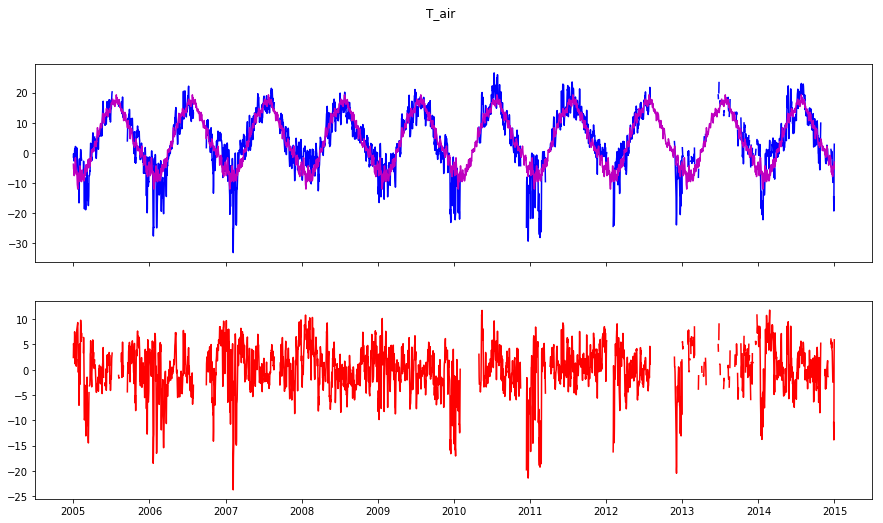

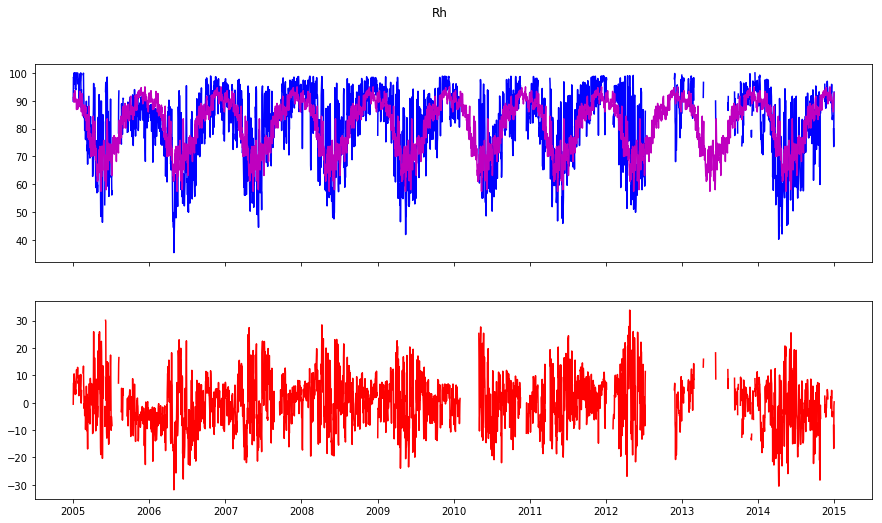

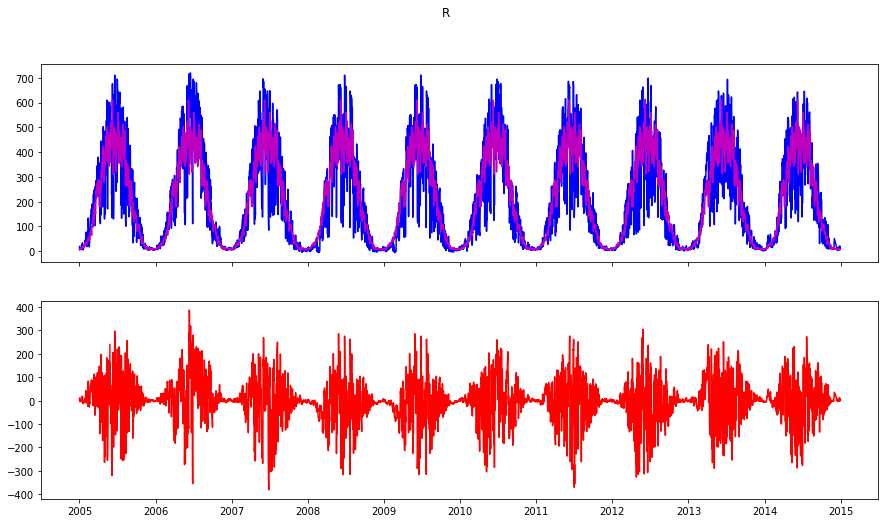

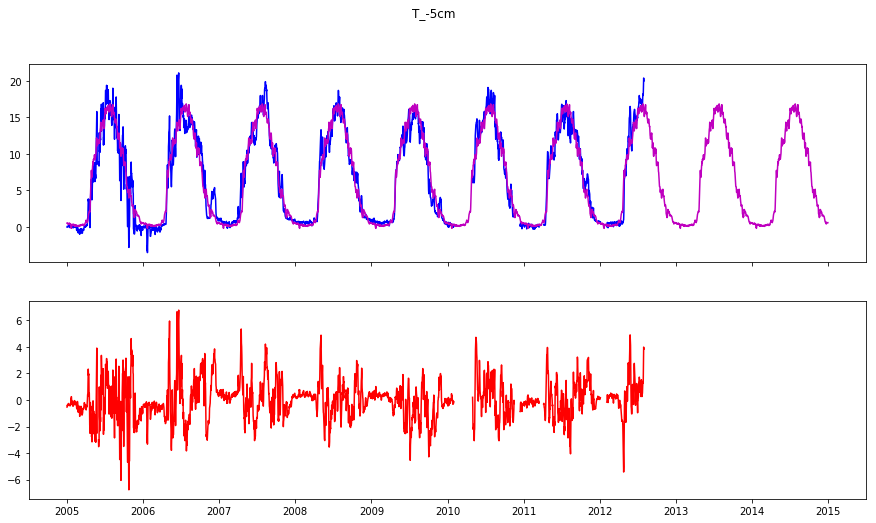

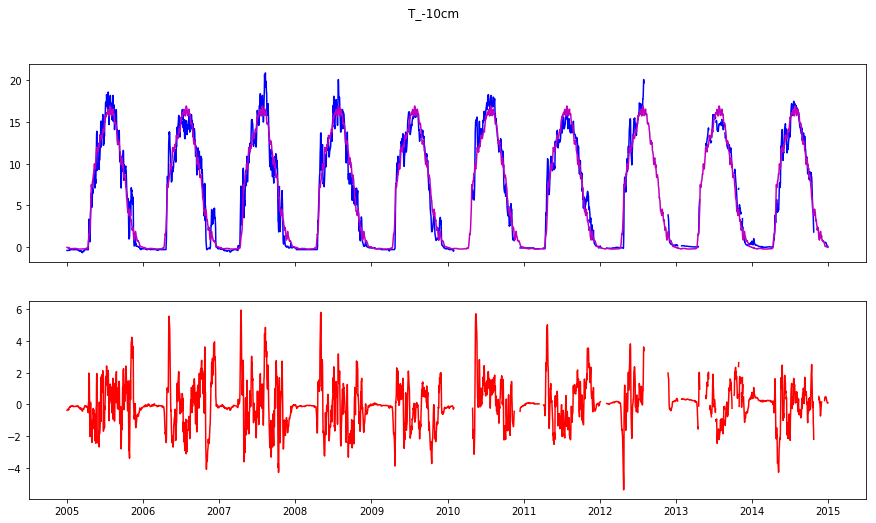

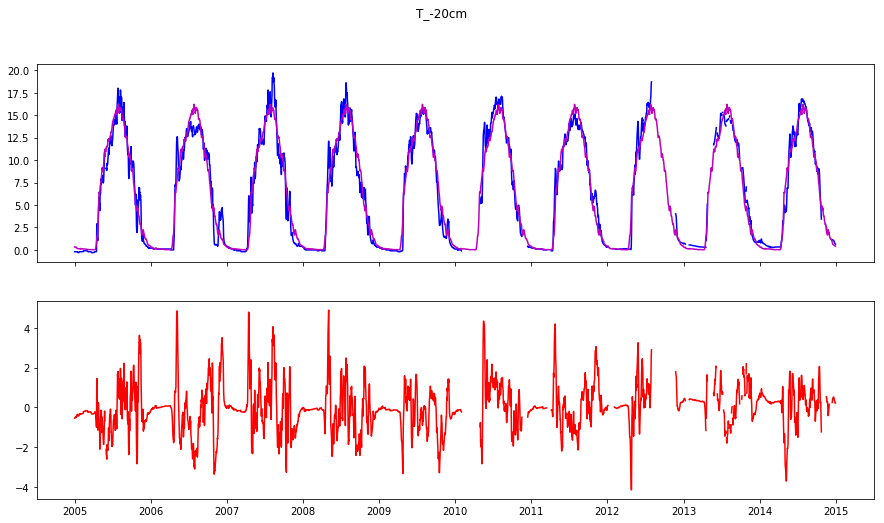

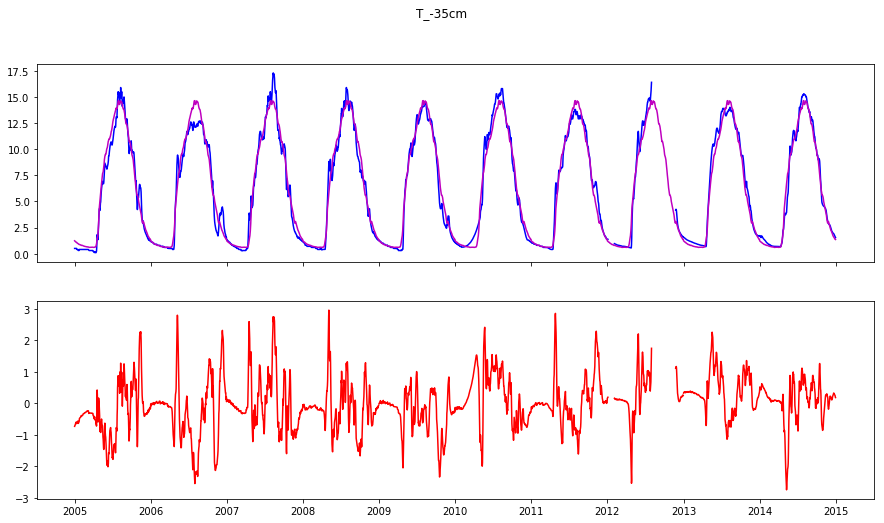

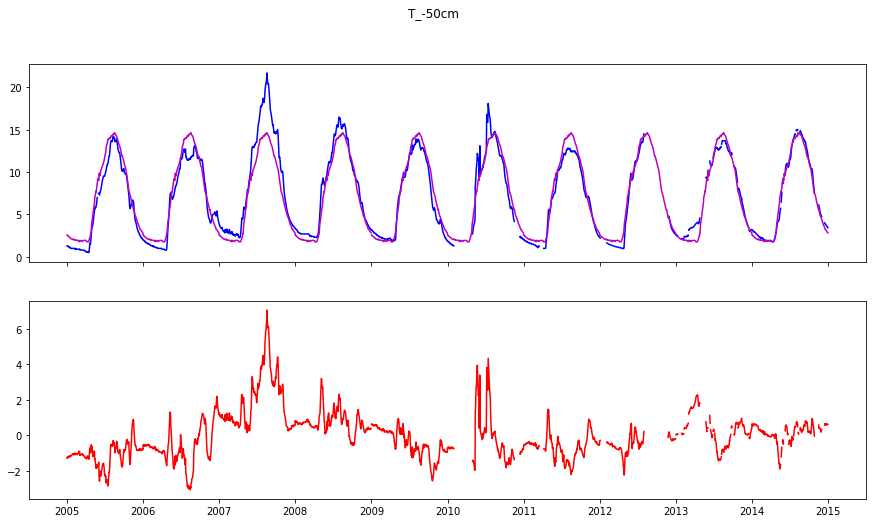

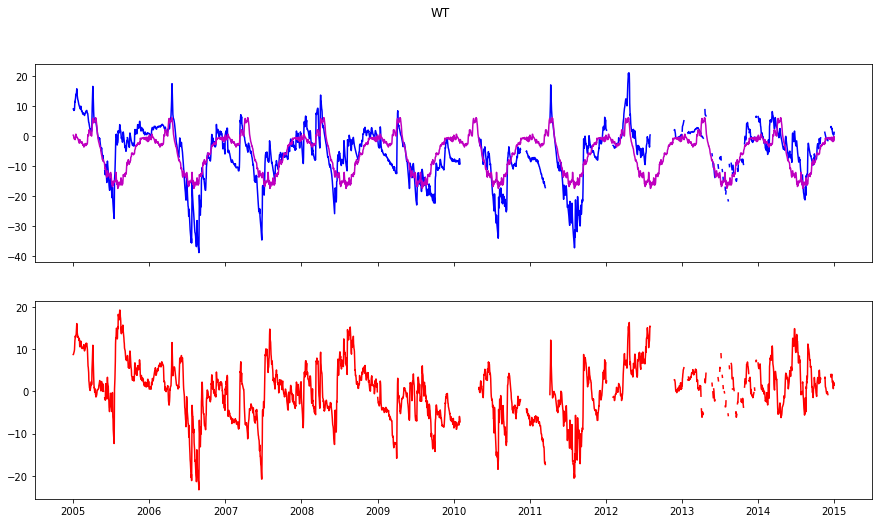

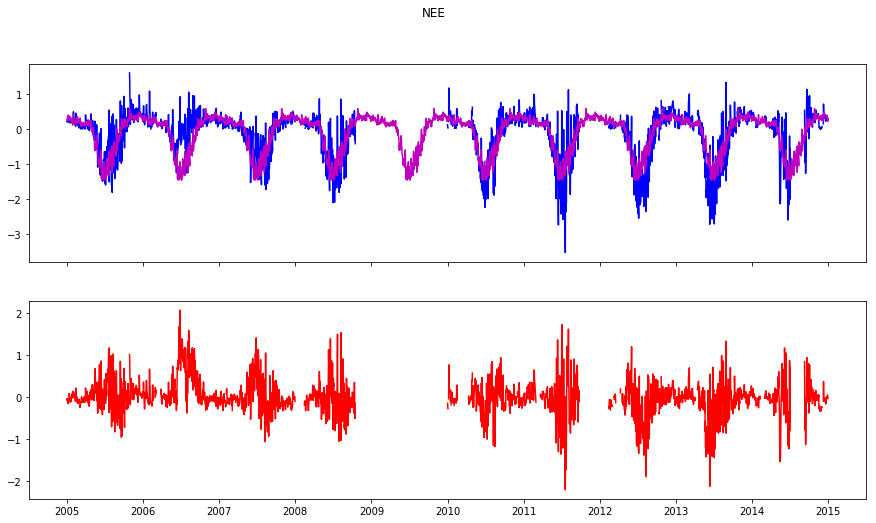

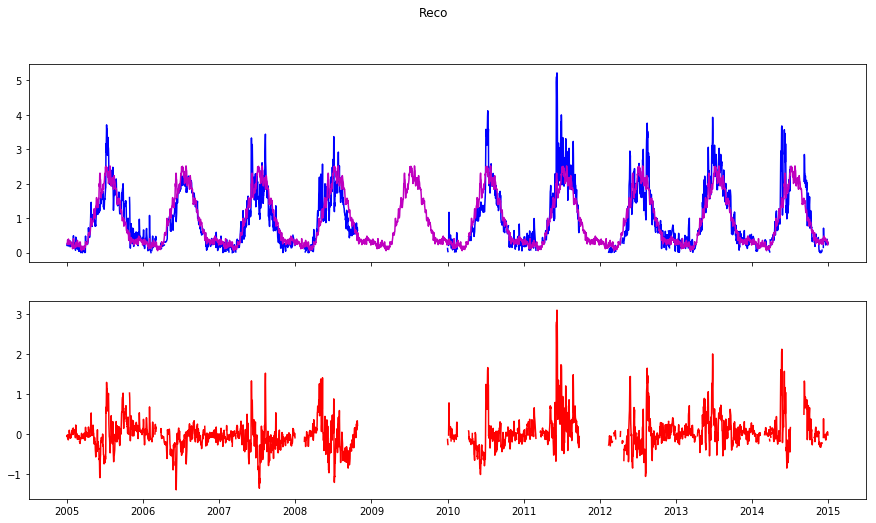

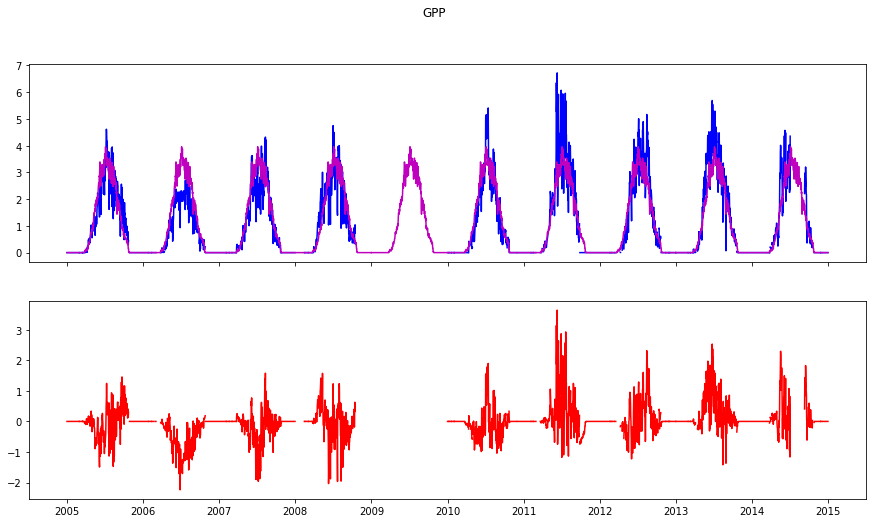

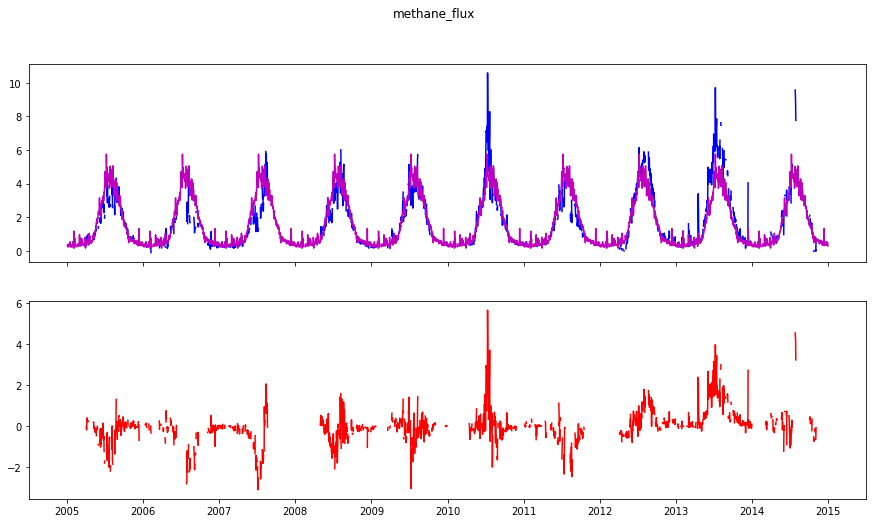

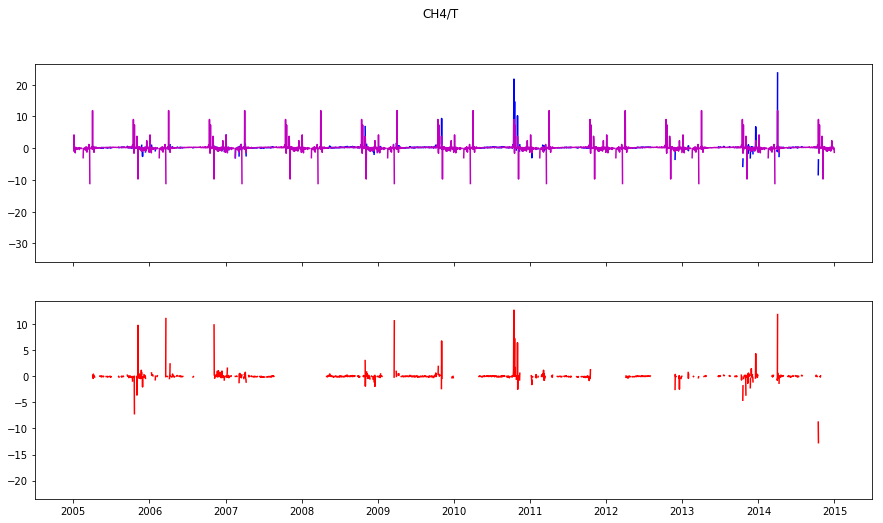

In [5]:
count = 0
for column in AnoTable:
    fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize = [15,8])
    fig.suptitle(AnoTable.columns[count])
    ax1.plot(table[column], 'b-')
    ax1.plot(MeanTable[column], 'm-')
    ax2.plot(AnoTable[column], 'r-')
    count = count + 1

#### Now plot histograms of the anomaly

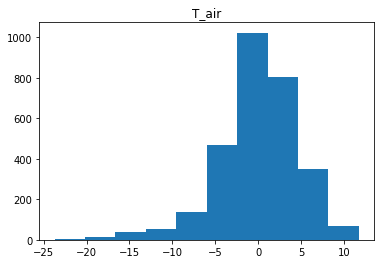

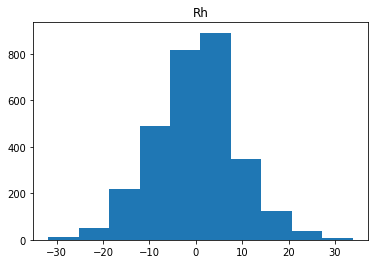

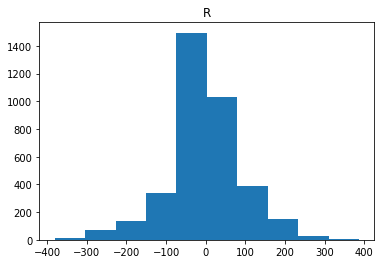

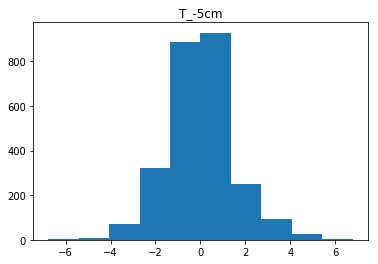

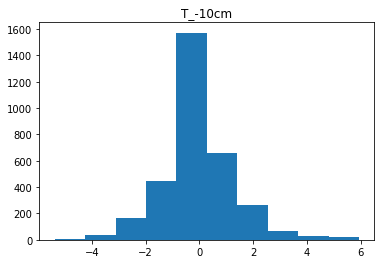

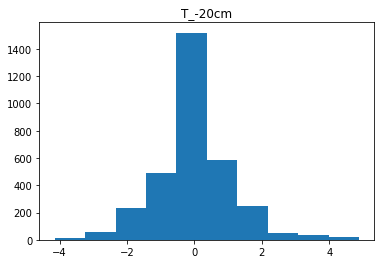

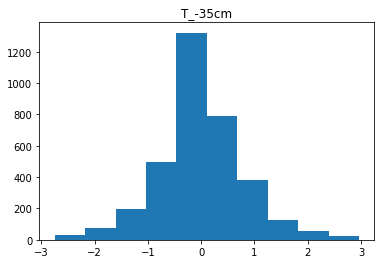

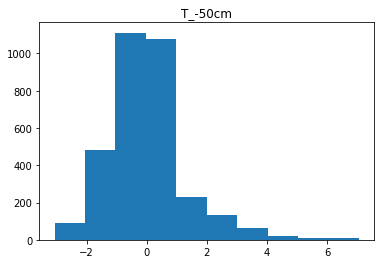

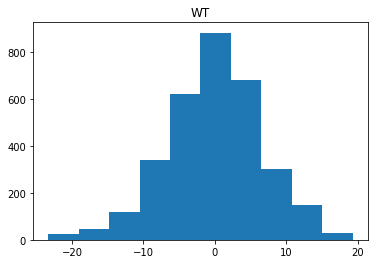

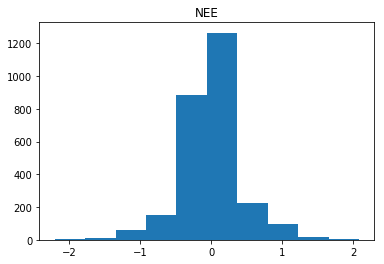

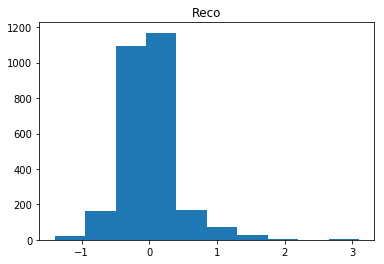

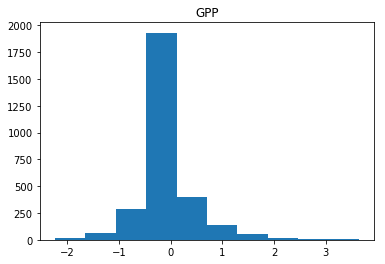

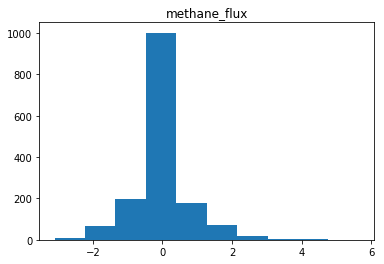

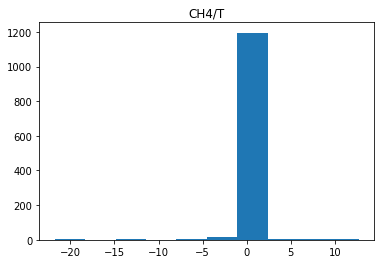

In [6]:
count = 0
for column in AnoTable:
    pylab.figure()
    pylab.hist((AnoTable.loc[~np.isnan(AnoTable[column]), column]))
    pylab.title(table.columns[count])
    count = count + 1

#### Observations
Reco, NEE, GPP, and Methane flux have distributions where most of the data is near the mean, and there are a few extreme outliers. May want to transform to better emphasize changes near the mean and increase the entropy of the anomaly dataset. This can be done without regard to what the final values of the transformed dataset are, as all that matters is the binning. Do a square root transform that preserves the sign of the original anomaly. 

In [7]:
def HistSqrtTransform(arr, plot_on=0, plot_title=''): #Input is an array, which may contain NaNs and zeros
    transformed = np.zeros(len(arr)) #initialize
    transformed = np.sqrt(np.abs(arr))*np.sign(arr)
   
    if plot_on:
        plt.hist(transformed[~np.isnan(transformed)])
        plt.title(plot_title)
    return transformed;

Now add new entries in the table for transformed values.

C:\Users\Laurel Larsen\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sign
  This is separate from the ipykernel package so we can avoid doing imports until


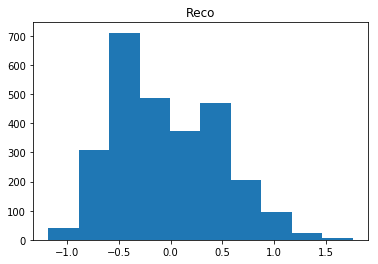

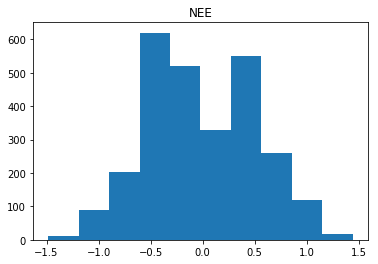

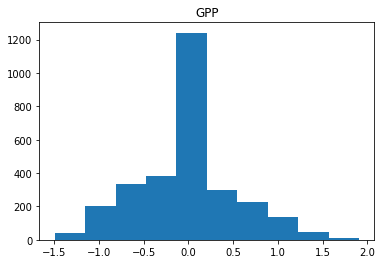

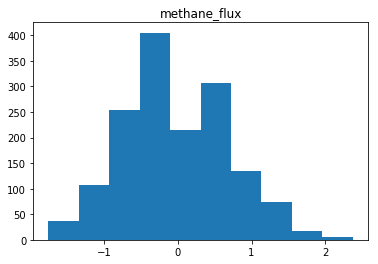

In [8]:
AnoTable['sqrt_Reco'] = HistSqrtTransform(AnoTable['Reco'], 1, 'Reco')
plt.figure()
AnoTable['sqrt_NEE'] = HistSqrtTransform(AnoTable['NEE'], 1, 'NEE')
plt.figure()
AnoTable['sqrt_GPP'] = HistSqrtTransform(AnoTable['GPP'], 1, 'GPP')
plt.figure()
AnoTable['sqrt_methane_flux'] = HistSqrtTransform(AnoTable['methane_flux'], 1, 'methane_flux');

That looks better!

In [9]:
AnoTable.head()

T_air         Rh       R    T_-5cm   T_-10cm   T_-20cm  \
Year_Month_Day                                                            
2005-01-01      2.3970  -0.550000  10.961 -0.533750 -0.375000 -0.548000   
2005-01-02      5.1430   7.110000  -4.196 -0.413750 -0.358000 -0.548000   
2005-01-03      4.5620   7.270000   2.287 -0.372500 -0.343000 -0.525000   
2005-01-04      3.0490   7.240000   2.269 -0.441250 -0.338000 -0.517000   
2005-01-05      4.8175  10.533333  -4.038 -0.388571 -0.306667 -0.487778   

                 T_-35cm   T_-50cm        WT       NEE      Reco  GPP  \
Year_Month_Day                                                          
2005-01-01     -0.731000 -1.276000  8.756000 -0.050000 -0.050000  0.0   
2005-01-02     -0.708000 -1.240000  8.790000 -0.067143 -0.067143  0.0   
2005-01-03     -0.700000 -1.219000  8.970000 -0.025714 -0.025714  0.0   
2005-01-04     -0.675000 -1.202000  9.083000 -0.108333 -0.108333  0.0   
2005-01-05     -0.637778 -1.231111  9.377778 -0.106667 -0.106667  0.0   

                methane_flux  CH4/T  sqrt_Reco  sqrt_NEE  sqrt_GPP  \
Year_Month_Day                                                       
2005-01-01               NaN    NaN  -0.223607 -0.223607       0.0   
2005-01-02               NaN    NaN  -0.259119 -0.259119       0.0   
2005-01-03               NaN    NaN  -0.160357 -0.160357       0.0   
2005-01-04               NaN    NaN  -0.329140 -0.329140       0.0   
2005-01-05               NaN    NaN  -0.326599 -0.326599       0.0   

                sqrt_methane_flux  
Year_Month_Day                     
2005-01-01                    NaN  
2005-01-02                    NaN  
2005-01-03                    NaN  
2005-01-04                    NaN  
2005-01-05                    NaN

### Nontransformed, t-1

In [10]:
# Adjust input for TE 
Table = copy.deepcopy(AnoTable)
numVr =  Table.shape[1] #3
data = copy.deepcopy(Table.iloc[:,np.arange(numVr)])
SourN = np.r_[np.arange(1,13)]# ,10)] transformed, np.arange(15, 18)]  # np.array([2,3])
SinN = np.array([13]) #18 transformed # transformed methane flux
LabelC = np.r_[np.array(['DateTime']),np.array(data.columns)]
DataM = pd.np.column_stack((data.index.astype(str), data.values))
print(np.r_[np.array([LabelC[0]]), np.array(LabelC[SinN]), np.array(LabelC[SourN])])
#LabelC, DataM[0:5,2], (data.shape)

['T_air' 'Rh' 'R' 'T_-5cm' 'T_-10cm' 'T_-20cm' 'T_-35cm' 'T_-50cm' 'WT'
 'NEE' 'Reco' 'GPP']


In [12]:
# Applying TE on the anomaly data
#importlib.reload(TEpython3)

sf = [-1,0,-1] #Uncomment this and run when want to use lag of 1. Set shift = sf in the function call.(RunNewTE2VarsSer2 only; when use T-lag, use RuneNewTEVarsSer instead)
Imat, Icritmat, Tfirstmat,  Tbiggestmat,Tcube_store,  Tcritcube_store = TEpython3.RunNewTE2VarsSer2(DataMatrix= DataM, LabelCell=LabelC, SinkNodes= SinN,SourceNodes=SourN, maxLag=365,shift=sf)

Beginning 2-variable analysis (serial) ...
Source node  0 T_air :=> Sink node  13 methane_flux
Lag  Sink Source
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
12 0 0
13 0 0
14 0 0
15 0 0
16 0 0
17 0 0
18 0 0
19 0 0
20 0 0
21 0 0
22 0 0
23 0 0
24 0 0
25 0 0
26 0 0
27 0 0
28 0 0
29 0 0
30 0 0
31 0 0
32 0 0
33 0 0
34 0 0
35 0 0
36 0 0
37 0 0
38 0 0
39 0 0
40 0 0
41 0 0
42 0 0
43 0 0
44 0 0
45 0 0
46 0 0
47 0 0
48 0 0
49 0 0
50 0 0
51 0 0
52 0 0
53 0 0
54 0 0
55 0 0
56 0 0
57 0 0
58 0 0
59 0 0
60 0 0
61 0 0
62 0 0
63 0 0
64 0 0
65 0 0
66 0 0
67 0 0
68 0 0
69 0 0
70 0 0
71 0 0
72 0 0
73 0 0
74 0 0
75 0 0
76 0 0
77 0 0
78 0 0
79 0 0
80 0 0
81 0 0
82 0 0
83 0 0
84 0 0
85 0 0
86 0 0
87 0 0
88 0 0
89 0 0
90 0 0
91 0 0
92 0 0
93 0 0
94 0 0
95 0 0
96 0 0
97 0 0
98 0 0
99 0 0
100 0 0
101 0 0
102 0 0
103 0 0
104 0 0
105 0 0
106 0 0
107 0 0
108 0 0
109 0 0
110 0 0
111 0 0
112 0 0
113 0 0
114 0 0
115 0 0
116 0 0
117 0 0
118 0 0
119 0 0
120 0 0
121 0 0
122 0 0
123 0 0
124 0 

306 0 2
307 0 2
308 0 2
309 0 2
310 0 2
311 0 2
312 0 2
313 0 2
314 0 2
315 0 2
316 0 2
317 0 2
318 0 2
319 0 2
320 0 2
321 0 2
322 0 2
323 0 2
324 0 2
325 0 2
326 0 2
327 0 2
328 0 2
329 0 2
330 0 2
331 0 2
332 0 2
333 0 2
334 0 2
335 0 2
336 0 2
337 0 2
338 0 2
339 0 2
340 0 2
341 0 2
342 0 2
343 0 2
344 0 2
345 0 2
346 0 2
347 0 2
348 0 2
349 0 2
350 0 2
351 0 2
352 0 2
353 0 2
354 0 2
355 0 2
356 0 2
357 0 2
358 0 2
359 0 2
360 0 2
361 0 2
362 0 2
363 0 2
364 0 2
Source node  3 T_-5cm :=> Sink node  13 methane_flux
Lag  Sink Source
0 0 3
1 0 3
2 0 3
3 0 3
4 0 3
5 0 3
6 0 3
7 0 3
8 0 3
9 0 3
10 0 3
11 0 3
12 0 3
13 0 3
14 0 3
15 0 3
16 0 3
17 0 3
18 0 3
19 0 3
20 0 3
21 0 3
22 0 3
23 0 3
24 0 3
25 0 3
26 0 3
27 0 3
28 0 3
29 0 3
30 0 3
31 0 3
32 0 3
33 0 3
34 0 3
35 0 3
36 0 3
37 0 3
38 0 3
39 0 3
40 0 3
41 0 3
42 0 3
43 0 3
44 0 3
45 0 3
46 0 3
47 0 3
48 0 3
49 0 3
50 0 3
51 0 3
52 0 3
53 0 3
54 0 3
55 0 3
56 0 3
57 0 3
58 0 3
59 0 3
60 0 3
61 0 3
62 0 3
63 0 3
64 0 3
65 0 3
66 0 3

251 0 5
252 0 5
253 0 5
254 0 5
255 0 5
256 0 5
257 0 5
258 0 5
259 0 5
260 0 5
261 0 5
262 0 5
263 0 5
264 0 5
265 0 5
266 0 5
267 0 5
268 0 5
269 0 5
270 0 5
271 0 5
272 0 5
273 0 5
274 0 5
275 0 5
276 0 5
277 0 5
278 0 5
279 0 5
280 0 5
281 0 5
282 0 5
283 0 5
284 0 5
285 0 5
286 0 5
287 0 5
288 0 5
289 0 5
290 0 5
291 0 5
292 0 5
293 0 5
294 0 5
295 0 5
296 0 5
297 0 5
298 0 5
299 0 5
300 0 5
301 0 5
302 0 5
303 0 5
304 0 5
305 0 5
306 0 5
307 0 5
308 0 5
309 0 5
310 0 5
311 0 5
312 0 5
313 0 5
314 0 5
315 0 5
316 0 5
317 0 5
318 0 5
319 0 5
320 0 5
321 0 5
322 0 5
323 0 5
324 0 5
325 0 5
326 0 5
327 0 5
328 0 5
329 0 5
330 0 5
331 0 5
332 0 5
333 0 5
334 0 5
335 0 5
336 0 5
337 0 5
338 0 5
339 0 5
340 0 5
341 0 5
342 0 5
343 0 5
344 0 5
345 0 5
346 0 5
347 0 5
348 0 5
349 0 5
350 0 5
351 0 5
352 0 5
353 0 5
354 0 5
355 0 5
356 0 5
357 0 5
358 0 5
359 0 5
360 0 5
361 0 5
362 0 5
363 0 5
364 0 5
Source node  6 T_-35cm :=> Sink node  13 methane_flux
Lag  Sink Source
0 0 6
1 0 6
2 0 6

197 0 8
198 0 8
199 0 8
200 0 8
201 0 8
202 0 8
203 0 8
204 0 8
205 0 8
206 0 8
207 0 8
208 0 8
209 0 8
210 0 8
211 0 8
212 0 8
213 0 8
214 0 8
215 0 8
216 0 8
217 0 8
218 0 8
219 0 8
220 0 8
221 0 8
222 0 8
223 0 8
224 0 8
225 0 8
226 0 8
227 0 8
228 0 8
229 0 8
230 0 8
231 0 8
232 0 8
233 0 8
234 0 8
235 0 8
236 0 8
237 0 8
238 0 8
239 0 8
240 0 8
241 0 8
242 0 8
243 0 8
244 0 8
245 0 8
246 0 8
247 0 8
248 0 8
249 0 8
250 0 8
251 0 8
252 0 8
253 0 8
254 0 8
255 0 8
256 0 8
257 0 8
258 0 8
259 0 8
260 0 8
261 0 8
262 0 8
263 0 8
264 0 8
265 0 8
266 0 8
267 0 8
268 0 8
269 0 8
270 0 8
271 0 8
272 0 8
273 0 8
274 0 8
275 0 8
276 0 8
277 0 8
278 0 8
279 0 8
280 0 8
281 0 8
282 0 8
283 0 8
284 0 8
285 0 8
286 0 8
287 0 8
288 0 8
289 0 8
290 0 8
291 0 8
292 0 8
293 0 8
294 0 8
295 0 8
296 0 8
297 0 8
298 0 8
299 0 8
300 0 8
301 0 8
302 0 8
303 0 8
304 0 8
305 0 8
306 0 8
307 0 8
308 0 8
309 0 8
310 0 8
311 0 8
312 0 8
313 0 8
314 0 8
315 0 8
316 0 8
317 0 8
318 0 8
319 0 8
320 0 8
321 0 8


85 0 11
86 0 11
87 0 11
88 0 11
89 0 11
90 0 11
91 0 11
92 0 11
93 0 11
94 0 11
95 0 11
96 0 11
97 0 11
98 0 11
99 0 11
100 0 11
101 0 11
102 0 11
103 0 11
104 0 11
105 0 11
106 0 11
107 0 11
108 0 11
109 0 11
110 0 11
111 0 11
112 0 11
113 0 11
114 0 11
115 0 11
116 0 11
117 0 11
118 0 11
119 0 11
120 0 11
121 0 11
122 0 11
123 0 11
124 0 11
125 0 11
126 0 11
127 0 11
128 0 11
129 0 11
130 0 11
131 0 11
132 0 11
133 0 11
134 0 11
135 0 11
136 0 11
137 0 11
138 0 11
139 0 11
140 0 11
141 0 11
142 0 11
143 0 11
144 0 11
145 0 11
146 0 11
147 0 11
148 0 11
149 0 11
150 0 11
151 0 11
152 0 11
153 0 11
154 0 11
155 0 11
156 0 11
157 0 11
158 0 11
159 0 11
160 0 11
161 0 11
162 0 11
163 0 11
164 0 11
165 0 11
166 0 11
167 0 11
168 0 11
169 0 11
170 0 11
171 0 11
172 0 11
173 0 11
174 0 11
175 0 11
176 0 11
177 0 11
178 0 11
179 0 11
180 0 11
181 0 11
182 0 11
183 0 11
184 0 11
185 0 11
186 0 11
187 0 11
188 0 11
189 0 11
190 0 11
191 0 11
192 0 11
193 0 11
194 0 11
195 0 11
196 0 11
197 0 1

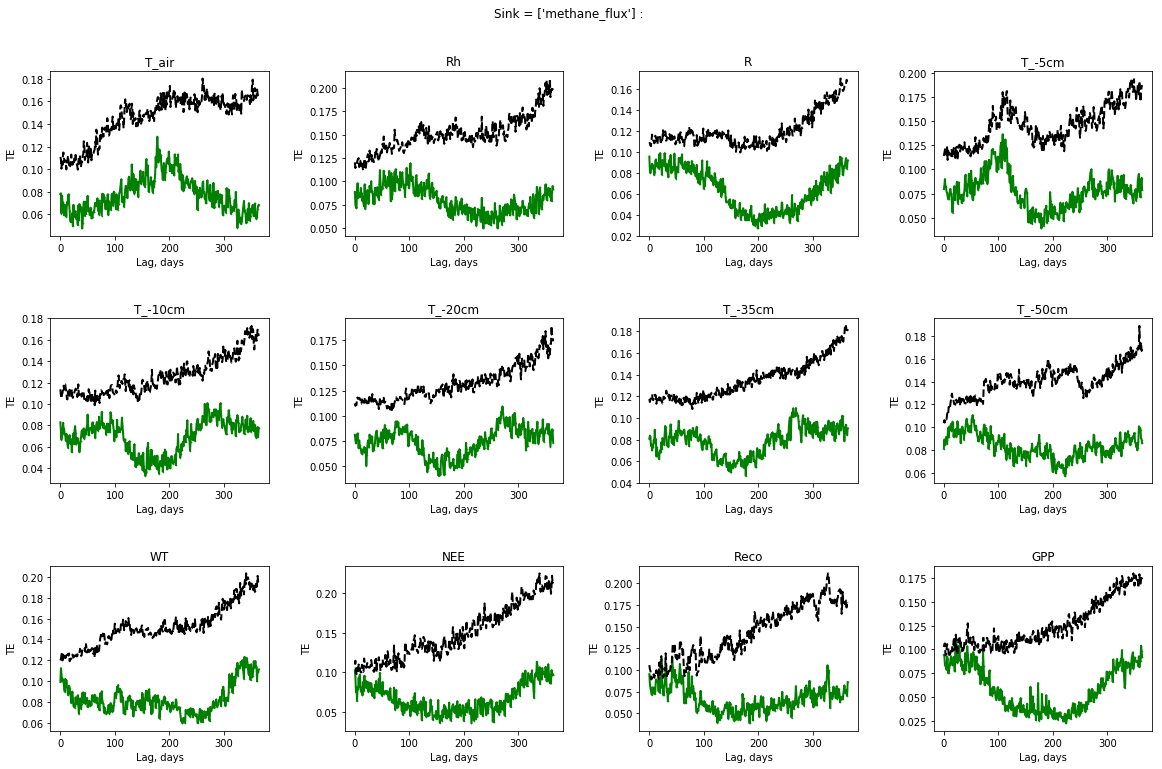

In [16]:
# Step 1/3 
# plotting results of TE one variable at a time
maxLag = 365

n = Tcube_store.shape[1]
plt.figure(figsize=[18,15])
AboveCritic = np.nan*np.ones([n,maxLag])
LagTime = np.nan*np.ones([n])
for i in np.arange(n):
    #i = 0  # Source id

    plt.subplot((int(n/4)+1), 4, i+1)
    plt.plot(np.arange(maxLag), Tcube_store[0,i,:].reshape(maxLag), color='green', marker='o', linewidth=2, markersize=0.5)
    plt.xlabel('Lag, days')
    plt.ylabel('TE')    

    plt.plot(np.arange(maxLag), Tcritcube_store[0,i,:].reshape(maxLag), color = 'black', linewidth=2, linestyle='dashed')
    #plt.title([LabelC[2], 'vs', LabelC[3]]) 
    plt.suptitle('Sink = %s :'%(LabelC[SinN]))
    #plt.title('Source = %s :'%(LabelC[i+2]))
    plt.title((LabelC[SourN[i]]))
    
    #plt.title('Source = %s : Sink = %s'%(LabelC[i+2],LabelC[1]))
    
    #plt.legend(('TE Estimated','TE Critical' ),loc='lower right')

    
    # Locating the critical Time/Delay
    AboveCritic[i,:] = (Tcube_store[0,i,:] - Tcritcube_store[0,i,:]).reshape(maxLag)
    LagTime[i] = np.argwhere(AboveCritic[i,:] == np.nanmax(AboveCritic[i,:]))[0]
    
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5,wspace=0.35)

### Transformed, t-1

In [18]:
# Adjust input for TE 
Table = copy.deepcopy(AnoTable)
numVr =  Table.shape[1] #3
data = copy.deepcopy(Table.iloc[:,np.arange(numVr)])
SourN = np.r_[np.arange(1,10), np.arange(15, 18)]  # np.array([2,3])
SinN = np.array([18]) #18 transformed # transformed methane flux
LabelC = np.r_[np.array(['DateTime']),np.array(data.columns)]
DataM = pd.np.column_stack((data.index.astype(str), data.values))
print(np.r_[np.array([LabelC[0]]), np.array(LabelC[SinN]), np.array(LabelC[SourN])])
#LabelC, DataM[0:5,2], (data.shape)

['DateTime' 'sqrt_methane_flux' 'T_air' 'Rh' 'R' 'T_-5cm' 'T_-10cm'
 'T_-20cm' 'T_-35cm' 'T_-50cm' 'WT' 'sqrt_Reco' 'sqrt_NEE' 'sqrt_GPP']


In [19]:
# Applying TE on the anomaly data
#importlib.reload(TEpython3)

sf = [-1,0,-1] #Uncomment this and run when want to use lag of 1. Set shift = sf in the function call.(RunNewTE2VarsSer2 only; when use T-lag, use RuneNewTEVarsSer instead)
Imat, Icritmat, Tfirstmat,  Tbiggestmat,Tcube_store,  Tcritcube_store = TEpython3.RunNewTE2VarsSer2(DataMatrix= DataM, LabelCell=LabelC, SinkNodes= SinN,SourceNodes=SourN, maxLag=365,shift=sf)

Beginning 2-variable analysis (serial) ...
Source node  0 T_air :=> Sink node  18 sqrt_methane_flux
Lag  Sink Source
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
12 0 0
13 0 0
14 0 0
15 0 0
16 0 0
17 0 0
18 0 0
19 0 0
20 0 0
21 0 0
22 0 0
23 0 0
24 0 0
25 0 0
26 0 0
27 0 0
28 0 0
29 0 0
30 0 0
31 0 0
32 0 0
33 0 0
34 0 0
35 0 0
36 0 0
37 0 0
38 0 0
39 0 0
40 0 0
41 0 0
42 0 0
43 0 0
44 0 0
45 0 0
46 0 0
47 0 0
48 0 0
49 0 0
50 0 0
51 0 0
52 0 0
53 0 0
54 0 0
55 0 0
56 0 0
57 0 0
58 0 0
59 0 0
60 0 0
61 0 0
62 0 0
63 0 0
64 0 0
65 0 0
66 0 0
67 0 0
68 0 0
69 0 0
70 0 0
71 0 0
72 0 0
73 0 0
74 0 0
75 0 0
76 0 0
77 0 0
78 0 0
79 0 0
80 0 0
81 0 0
82 0 0
83 0 0
84 0 0
85 0 0
86 0 0
87 0 0
88 0 0
89 0 0
90 0 0
91 0 0
92 0 0
93 0 0
94 0 0
95 0 0
96 0 0
97 0 0
98 0 0
99 0 0
100 0 0
101 0 0
102 0 0
103 0 0
104 0 0
105 0 0
106 0 0
107 0 0
108 0 0
109 0 0
110 0 0
111 0 0
112 0 0
113 0 0
114 0 0
115 0 0
116 0 0
117 0 0
118 0 0
119 0 0
120 0 0
121 0 0
122 0 0
123 0 0
1

304 0 2
305 0 2
306 0 2
307 0 2
308 0 2
309 0 2
310 0 2
311 0 2
312 0 2
313 0 2
314 0 2
315 0 2
316 0 2
317 0 2
318 0 2
319 0 2
320 0 2
321 0 2
322 0 2
323 0 2
324 0 2
325 0 2
326 0 2
327 0 2
328 0 2
329 0 2
330 0 2
331 0 2
332 0 2
333 0 2
334 0 2
335 0 2
336 0 2
337 0 2
338 0 2
339 0 2
340 0 2
341 0 2
342 0 2
343 0 2
344 0 2
345 0 2
346 0 2
347 0 2
348 0 2
349 0 2
350 0 2
351 0 2
352 0 2
353 0 2
354 0 2
355 0 2
356 0 2
357 0 2
358 0 2
359 0 2
360 0 2
361 0 2
362 0 2
363 0 2
364 0 2
Source node  3 T_-5cm :=> Sink node  18 sqrt_methane_flux
Lag  Sink Source
0 0 3
1 0 3
2 0 3
3 0 3
4 0 3
5 0 3
6 0 3
7 0 3
8 0 3
9 0 3
10 0 3
11 0 3
12 0 3
13 0 3
14 0 3
15 0 3
16 0 3
17 0 3
18 0 3
19 0 3
20 0 3
21 0 3
22 0 3
23 0 3
24 0 3
25 0 3
26 0 3
27 0 3
28 0 3
29 0 3
30 0 3
31 0 3
32 0 3
33 0 3
34 0 3
35 0 3
36 0 3
37 0 3
38 0 3
39 0 3
40 0 3
41 0 3
42 0 3
43 0 3
44 0 3
45 0 3
46 0 3
47 0 3
48 0 3
49 0 3
50 0 3
51 0 3
52 0 3
53 0 3
54 0 3
55 0 3
56 0 3
57 0 3
58 0 3
59 0 3
60 0 3
61 0 3
62 0 3
63 0 3

246 0 5
247 0 5
248 0 5
249 0 5
250 0 5
251 0 5
252 0 5
253 0 5
254 0 5
255 0 5
256 0 5
257 0 5
258 0 5
259 0 5
260 0 5
261 0 5
262 0 5
263 0 5
264 0 5
265 0 5
266 0 5
267 0 5
268 0 5
269 0 5
270 0 5
271 0 5
272 0 5
273 0 5
274 0 5
275 0 5
276 0 5
277 0 5
278 0 5
279 0 5
280 0 5
281 0 5
282 0 5
283 0 5
284 0 5
285 0 5
286 0 5
287 0 5
288 0 5
289 0 5
290 0 5
291 0 5
292 0 5
293 0 5
294 0 5
295 0 5
296 0 5
297 0 5
298 0 5
299 0 5
300 0 5
301 0 5
302 0 5
303 0 5
304 0 5
305 0 5
306 0 5
307 0 5
308 0 5
309 0 5
310 0 5
311 0 5
312 0 5
313 0 5
314 0 5
315 0 5
316 0 5
317 0 5
318 0 5
319 0 5
320 0 5
321 0 5
322 0 5
323 0 5
324 0 5
325 0 5
326 0 5
327 0 5
328 0 5
329 0 5
330 0 5
331 0 5
332 0 5
333 0 5
334 0 5
335 0 5
336 0 5
337 0 5
338 0 5
339 0 5
340 0 5
341 0 5
342 0 5
343 0 5
344 0 5
345 0 5
346 0 5
347 0 5
348 0 5
349 0 5
350 0 5
351 0 5
352 0 5
353 0 5
354 0 5
355 0 5
356 0 5
357 0 5
358 0 5
359 0 5
360 0 5
361 0 5
362 0 5
363 0 5
364 0 5
Source node  6 T_-35cm :=> Sink node  18 sqrt_me

189 0 8
190 0 8
191 0 8
192 0 8
193 0 8
194 0 8
195 0 8
196 0 8
197 0 8
198 0 8
199 0 8
200 0 8
201 0 8
202 0 8
203 0 8
204 0 8
205 0 8
206 0 8
207 0 8
208 0 8
209 0 8
210 0 8
211 0 8
212 0 8
213 0 8
214 0 8
215 0 8
216 0 8
217 0 8
218 0 8
219 0 8
220 0 8
221 0 8
222 0 8
223 0 8
224 0 8
225 0 8
226 0 8
227 0 8
228 0 8
229 0 8
230 0 8
231 0 8
232 0 8
233 0 8
234 0 8
235 0 8
236 0 8
237 0 8
238 0 8
239 0 8
240 0 8
241 0 8
242 0 8
243 0 8
244 0 8
245 0 8
246 0 8
247 0 8
248 0 8
249 0 8
250 0 8
251 0 8
252 0 8
253 0 8
254 0 8
255 0 8
256 0 8
257 0 8
258 0 8
259 0 8
260 0 8
261 0 8
262 0 8
263 0 8
264 0 8
265 0 8
266 0 8
267 0 8
268 0 8
269 0 8
270 0 8
271 0 8
272 0 8
273 0 8
274 0 8
275 0 8
276 0 8
277 0 8
278 0 8
279 0 8
280 0 8
281 0 8
282 0 8
283 0 8
284 0 8
285 0 8
286 0 8
287 0 8
288 0 8
289 0 8
290 0 8
291 0 8
292 0 8
293 0 8
294 0 8
295 0 8
296 0 8
297 0 8
298 0 8
299 0 8
300 0 8
301 0 8
302 0 8
303 0 8
304 0 8
305 0 8
306 0 8
307 0 8
308 0 8
309 0 8
310 0 8
311 0 8
312 0 8
313 0 8


73 0 11
74 0 11
75 0 11
76 0 11
77 0 11
78 0 11
79 0 11
80 0 11
81 0 11
82 0 11
83 0 11
84 0 11
85 0 11
86 0 11
87 0 11
88 0 11
89 0 11
90 0 11
91 0 11
92 0 11
93 0 11
94 0 11
95 0 11
96 0 11
97 0 11
98 0 11
99 0 11
100 0 11
101 0 11
102 0 11
103 0 11
104 0 11
105 0 11
106 0 11
107 0 11
108 0 11
109 0 11
110 0 11
111 0 11
112 0 11
113 0 11
114 0 11
115 0 11
116 0 11
117 0 11
118 0 11
119 0 11
120 0 11
121 0 11
122 0 11
123 0 11
124 0 11
125 0 11
126 0 11
127 0 11
128 0 11
129 0 11
130 0 11
131 0 11
132 0 11
133 0 11
134 0 11
135 0 11
136 0 11
137 0 11
138 0 11
139 0 11
140 0 11
141 0 11
142 0 11
143 0 11
144 0 11
145 0 11
146 0 11
147 0 11
148 0 11
149 0 11
150 0 11
151 0 11
152 0 11
153 0 11
154 0 11
155 0 11
156 0 11
157 0 11
158 0 11
159 0 11
160 0 11
161 0 11
162 0 11
163 0 11
164 0 11
165 0 11
166 0 11
167 0 11
168 0 11
169 0 11
170 0 11
171 0 11
172 0 11
173 0 11
174 0 11
175 0 11
176 0 11
177 0 11
178 0 11
179 0 11
180 0 11
181 0 11
182 0 11
183 0 11
184 0 11
185 0 11
186 0 11
1

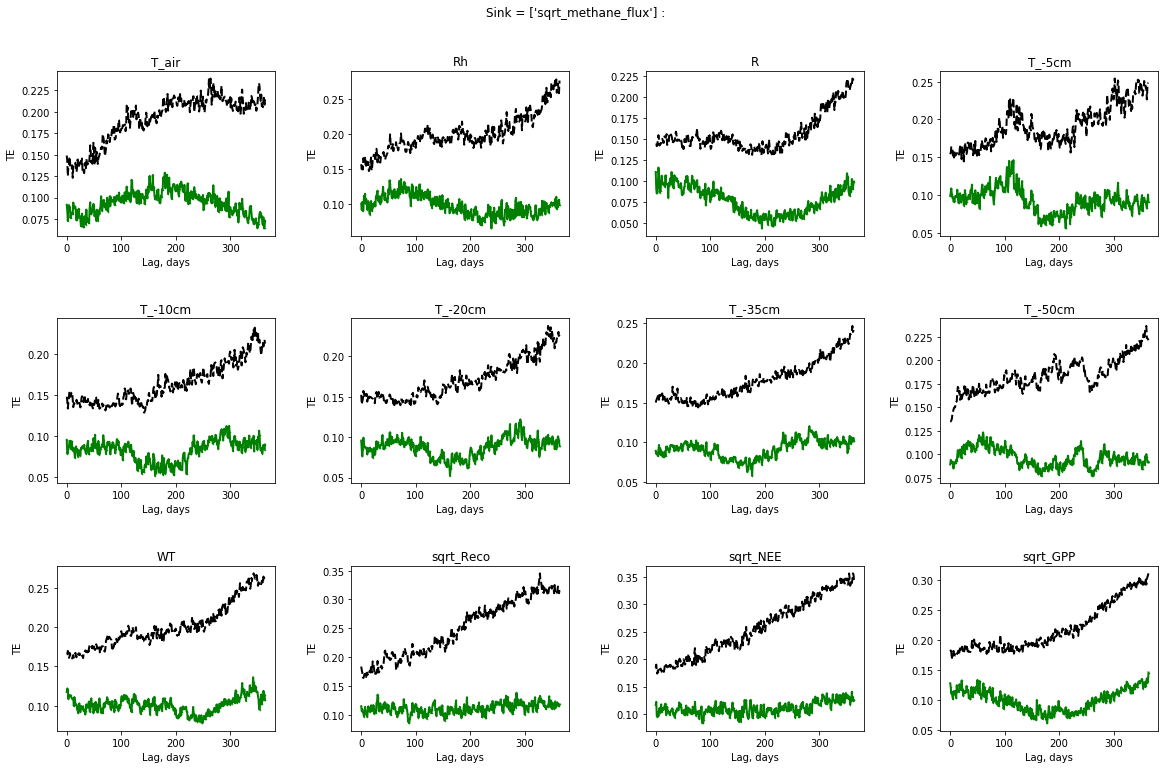

In [20]:
# Step 1/3 
# plotting results of TE one variable at a time
maxLag = 365

n = Tcube_store.shape[1]
plt.figure(figsize=[18,15])
AboveCritic = np.nan*np.ones([n,maxLag])
LagTime = np.nan*np.ones([n])
for i in np.arange(n):
    #i = 0  # Source id

    plt.subplot((int(n/4)+1), 4, i+1)
    plt.plot(np.arange(maxLag), Tcube_store[0,i,:].reshape(maxLag), color='green', marker='o', linewidth=2, markersize=0.5)
    plt.xlabel('Lag, days')
    plt.ylabel('TE')    

    plt.plot(np.arange(maxLag), Tcritcube_store[0,i,:].reshape(maxLag), color = 'black', linewidth=2, linestyle='dashed')
    #plt.title([LabelC[2], 'vs', LabelC[3]]) 
    plt.suptitle('Sink = %s :'%(LabelC[SinN]))
    #plt.title('Source = %s :'%(LabelC[i+2]))
    plt.title((LabelC[SourN[i]]))
    
    #plt.title('Source = %s : Sink = %s'%(LabelC[i+2],LabelC[1]))
    
    #plt.legend(('TE Estimated','TE Critical' ),loc='lower right')

    
    # Locating the critical Time/Delay
    AboveCritic[i,:] = (Tcube_store[0,i,:] - Tcritcube_store[0,i,:]).reshape(maxLag)
    LagTime[i] = np.argwhere(AboveCritic[i,:] == np.nanmax(AboveCritic[i,:]))[0]
    
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5,wspace=0.35)

### Transformed, t-tau

In [38]:
# Adjust input for TE 
Table = copy.deepcopy(AnoTable)
numVr =  Table.shape[1] #3
data = copy.deepcopy(Table.iloc[:,np.arange(numVr)])
SourN = np.r_[np.arange(1,10), np.arange(15, 18)]  # np.array([2,3])
SinN = np.array([18]) #18 transformed # transformed methane flux
LabelC = np.r_[np.array(['DateTime']),np.array(data.columns)]
DataM = pd.np.column_stack((data.index.astype(str), data.values))
print(np.r_[np.array([LabelC[0]]), np.array(LabelC[SinN]), np.array(LabelC[SourN])])
#LabelC, DataM[0:5,2], (data.shape)

['DateTime' 'sqrt_methane_flux' 'T_air' 'Rh' 'R' 'T_-5cm' 'T_-10cm'
 'T_-20cm' 'T_-35cm' 'T_-50cm' 'WT' 'sqrt_Reco' 'sqrt_NEE' 'sqrt_GPP']


In [39]:
# Applying TE on the anomaly data
importlib.reload(TEpython3)

#sf = [-1,0,-1] #Uncomment this and run when want to use lag of 1. Set shift = sf in the function call.(RunNewTE2VarsSer2 only; when use T-lag, use RuneNewTEVarsSer instead)
Imat, Icritmat, Tfirstmat,  Tbiggestmat,Tcube_store,  Tcritcube_store = TEpython3.RunNewTE2VarsSer(DataMatrix= DataM, LabelCell=LabelC, SinkNodes= SinN,SourceNodes=SourN, maxLag=365)

Beginning 2-variable analysis (serial) ...
Source node  0 T_air :=> Sink node  18 sqrt_methane_flux
Lag  Sink Source
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
12 0 0
13 0 0
14 0 0
15 0 0
16 0 0
17 0 0
18 0 0
19 0 0
20 0 0
21 0 0
22 0 0
23 0 0
24 0 0
25 0 0
26 0 0
27 0 0
28 0 0
29 0 0
30 0 0
31 0 0
32 0 0
33 0 0
34 0 0
35 0 0
36 0 0
37 0 0
38 0 0
39 0 0
40 0 0
41 0 0
42 0 0
43 0 0
44 0 0
45 0 0
46 0 0
47 0 0
48 0 0
49 0 0
50 0 0
51 0 0
52 0 0
53 0 0
54 0 0
55 0 0
56 0 0
57 0 0
58 0 0
59 0 0
60 0 0
61 0 0
62 0 0
63 0 0
64 0 0
65 0 0
66 0 0
67 0 0
68 0 0
69 0 0
70 0 0
71 0 0
72 0 0
73 0 0
74 0 0
75 0 0
76 0 0
77 0 0
78 0 0
79 0 0
80 0 0
81 0 0
82 0 0
83 0 0
84 0 0
85 0 0
86 0 0
87 0 0
88 0 0
89 0 0
90 0 0
91 0 0
92 0 0
93 0 0
94 0 0
95 0 0
96 0 0
97 0 0
98 0 0
99 0 0
100 0 0
101 0 0
102 0 0
103 0 0
104 0 0
105 0 0
106 0 0
107 0 0
108 0 0
109 0 0
110 0 0
111 0 0
112 0 0
113 0 0
114 0 0
115 0 0
116 0 0
117 0 0
118 0 0
119 0 0
120 0 0
121 0 0
122 0 0
123 0 0
1

304 0 2
305 0 2
306 0 2
307 0 2
308 0 2
309 0 2
310 0 2
311 0 2
312 0 2
313 0 2
314 0 2
315 0 2
316 0 2
317 0 2
318 0 2
319 0 2
320 0 2
321 0 2
322 0 2
323 0 2
324 0 2
325 0 2
326 0 2
327 0 2
328 0 2
329 0 2
330 0 2
331 0 2
332 0 2
333 0 2
334 0 2
335 0 2
336 0 2
337 0 2
338 0 2
339 0 2
340 0 2
341 0 2
342 0 2
343 0 2
344 0 2
345 0 2
346 0 2
347 0 2
348 0 2
349 0 2
350 0 2
351 0 2
352 0 2
353 0 2
354 0 2
355 0 2
356 0 2
357 0 2
358 0 2
359 0 2
360 0 2
361 0 2
362 0 2
363 0 2
364 0 2
Source node  3 T_-5cm :=> Sink node  18 sqrt_methane_flux
Lag  Sink Source
0 0 3
1 0 3
2 0 3
3 0 3
4 0 3
5 0 3
6 0 3
7 0 3
8 0 3
9 0 3
10 0 3
11 0 3
12 0 3
13 0 3
14 0 3
15 0 3
16 0 3
17 0 3
18 0 3
19 0 3
20 0 3
21 0 3
22 0 3
23 0 3
24 0 3
25 0 3
26 0 3
27 0 3
28 0 3
29 0 3
30 0 3
31 0 3
32 0 3
33 0 3
34 0 3
35 0 3
36 0 3
37 0 3
38 0 3
39 0 3
40 0 3
41 0 3
42 0 3
43 0 3
44 0 3
45 0 3
46 0 3
47 0 3
48 0 3
49 0 3
50 0 3
51 0 3
52 0 3
53 0 3
54 0 3
55 0 3
56 0 3
57 0 3
58 0 3
59 0 3
60 0 3
61 0 3
62 0 3
63 0 3

247 0 5
248 0 5
249 0 5
250 0 5
251 0 5
252 0 5
253 0 5
254 0 5
255 0 5
256 0 5
257 0 5
258 0 5
259 0 5
260 0 5
261 0 5
262 0 5
263 0 5
264 0 5
265 0 5
266 0 5
267 0 5
268 0 5
269 0 5
270 0 5
271 0 5
272 0 5
273 0 5
274 0 5
275 0 5
276 0 5
277 0 5
278 0 5
279 0 5
280 0 5
281 0 5
282 0 5
283 0 5
284 0 5
285 0 5
286 0 5
287 0 5
288 0 5
289 0 5
290 0 5
291 0 5
292 0 5
293 0 5
294 0 5
295 0 5
296 0 5
297 0 5
298 0 5
299 0 5
300 0 5
301 0 5
302 0 5
303 0 5
304 0 5
305 0 5
306 0 5
307 0 5
308 0 5
309 0 5
310 0 5
311 0 5
312 0 5
313 0 5
314 0 5
315 0 5
316 0 5
317 0 5
318 0 5
319 0 5
320 0 5
321 0 5
322 0 5
323 0 5
324 0 5
325 0 5
326 0 5
327 0 5
328 0 5
329 0 5
330 0 5
331 0 5
332 0 5
333 0 5
334 0 5
335 0 5
336 0 5
337 0 5
338 0 5
339 0 5
340 0 5
341 0 5
342 0 5
343 0 5
344 0 5
345 0 5
346 0 5
347 0 5
348 0 5
349 0 5
350 0 5
351 0 5
352 0 5
353 0 5
354 0 5
355 0 5
356 0 5
357 0 5
358 0 5
359 0 5
360 0 5
361 0 5
362 0 5
363 0 5
364 0 5
Source node  6 T_-35cm :=> Sink node  18 sqrt_methane_fl

190 0 8
191 0 8
192 0 8
193 0 8
194 0 8
195 0 8
196 0 8
197 0 8
198 0 8
199 0 8
200 0 8
201 0 8
202 0 8
203 0 8
204 0 8
205 0 8
206 0 8
207 0 8
208 0 8
209 0 8
210 0 8
211 0 8
212 0 8
213 0 8
214 0 8
215 0 8
216 0 8
217 0 8
218 0 8
219 0 8
220 0 8
221 0 8
222 0 8
223 0 8
224 0 8
225 0 8
226 0 8
227 0 8
228 0 8
229 0 8
230 0 8
231 0 8
232 0 8
233 0 8
234 0 8
235 0 8
236 0 8
237 0 8
238 0 8
239 0 8
240 0 8
241 0 8
242 0 8
243 0 8
244 0 8
245 0 8
246 0 8
247 0 8
248 0 8
249 0 8
250 0 8
251 0 8
252 0 8
253 0 8
254 0 8
255 0 8
256 0 8
257 0 8
258 0 8
259 0 8
260 0 8
261 0 8
262 0 8
263 0 8
264 0 8
265 0 8
266 0 8
267 0 8
268 0 8
269 0 8
270 0 8
271 0 8
272 0 8
273 0 8
274 0 8
275 0 8
276 0 8
277 0 8
278 0 8
279 0 8
280 0 8
281 0 8
282 0 8
283 0 8
284 0 8
285 0 8
286 0 8
287 0 8
288 0 8
289 0 8
290 0 8
291 0 8
292 0 8
293 0 8
294 0 8
295 0 8
296 0 8
297 0 8
298 0 8
299 0 8
300 0 8
301 0 8
302 0 8
303 0 8
304 0 8
305 0 8
306 0 8
307 0 8
308 0 8
309 0 8
310 0 8
311 0 8
312 0 8
313 0 8
314 0 8


74 0 11
75 0 11
76 0 11
77 0 11
78 0 11
79 0 11
80 0 11
81 0 11
82 0 11
83 0 11
84 0 11
85 0 11
86 0 11
87 0 11
88 0 11
89 0 11
90 0 11
91 0 11
92 0 11
93 0 11
94 0 11
95 0 11
96 0 11
97 0 11
98 0 11
99 0 11
100 0 11
101 0 11
102 0 11
103 0 11
104 0 11
105 0 11
106 0 11
107 0 11
108 0 11
109 0 11
110 0 11
111 0 11
112 0 11
113 0 11
114 0 11
115 0 11
116 0 11
117 0 11
118 0 11
119 0 11
120 0 11
121 0 11
122 0 11
123 0 11
124 0 11
125 0 11
126 0 11
127 0 11
128 0 11
129 0 11
130 0 11
131 0 11
132 0 11
133 0 11
134 0 11
135 0 11
136 0 11
137 0 11
138 0 11
139 0 11
140 0 11
141 0 11
142 0 11
143 0 11
144 0 11
145 0 11
146 0 11
147 0 11
148 0 11
149 0 11
150 0 11
151 0 11
152 0 11
153 0 11
154 0 11
155 0 11
156 0 11
157 0 11
158 0 11
159 0 11
160 0 11
161 0 11
162 0 11
163 0 11
164 0 11
165 0 11
166 0 11
167 0 11
168 0 11
169 0 11
170 0 11
171 0 11
172 0 11
173 0 11
174 0 11
175 0 11
176 0 11
177 0 11
178 0 11
179 0 11
180 0 11
181 0 11
182 0 11
183 0 11
184 0 11
185 0 11
186 0 11
187 0 11


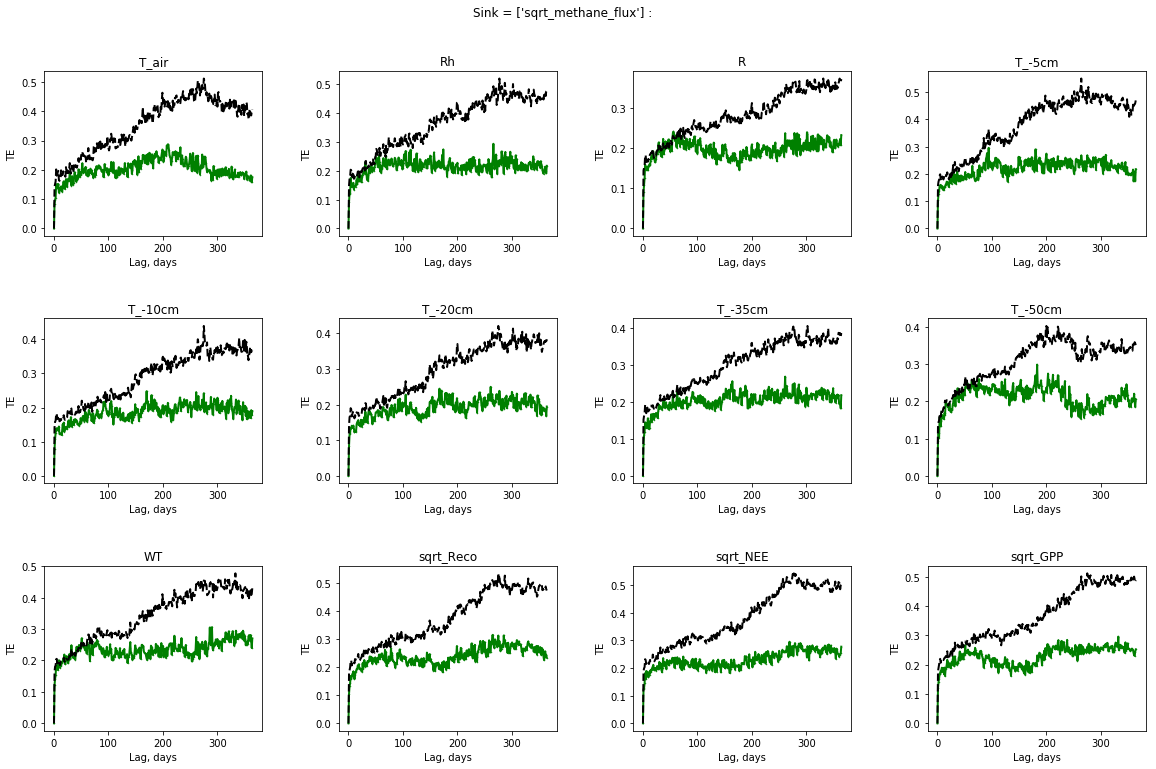

In [45]:
# Step 1/3 
# plotting results of TE one variable at a time
maxLag = 365

n = Tcube_store.shape[1]
plt.figure(figsize=[18,15])
AboveCritic = np.nan*np.ones([n,maxLag])
LagTime = np.nan*np.ones([n])
for i in np.arange(n):
    #i = 0  # Source id

    plt.subplot((int(n/4)+1), 4, i+1)
    plt.plot(np.arange(maxLag), Tcube_store[0,i,:].reshape(maxLag), color='green', marker='o', linewidth=2, markersize=0.5)
    plt.xlabel('Lag, days')
    plt.ylabel('TE')    

    plt.plot(np.arange(maxLag), Tcritcube_store[0,i,:].reshape(maxLag), color = 'black', linewidth=2, linestyle='dashed')
    #plt.title([LabelC[2], 'vs', LabelC[3]]) 
    plt.suptitle('Sink = %s :'%(LabelC[SinN]))
    #plt.title('Source = %s :'%(LabelC[i+2]))
    plt.title((LabelC[SourN[i]]))
    
    #plt.title('Source = %s : Sink = %s'%(LabelC[i+2],LabelC[1]))
    
    #plt.legend(('TE Estimated','TE Critical' ),loc='lower right')

    
    # Locating the critical Time/Delay
    AboveCritic[i,:] = (Tcube_store[0,i,:] - Tcritcube_store[0,i,:]).reshape(maxLag)
    LagTime[i] = np.argwhere(AboveCritic[i,:] == np.nanmax(AboveCritic[i,:]))[0]
    
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5,wspace=0.35)

### Non transformed, t-tau

In [46]:
# Adjust input for TE 
Table = copy.deepcopy(AnoTable)
numVr =  Table.shape[1] #3
data = copy.deepcopy(Table.iloc[:,np.arange(numVr)])
SourN = np.r_[np.arange(1,13)]# ,10)] transformed, np.arange(15, 18)]  # np.array([2,3])
SinN = np.array([13]) #18 transformed # transformed methane flux
LabelC = np.r_[np.array(['DateTime']),np.array(data.columns)]
DataM = pd.np.column_stack((data.index.astype(str), data.values))
print(np.r_[np.array([LabelC[0]]), np.array(LabelC[SinN]), np.array(LabelC[SourN])])
#LabelC, DataM[0:5,2], (data.shape)

['DateTime' 'methane_flux' 'T_air' 'Rh' 'R' 'T_-5cm' 'T_-10cm' 'T_-20cm'
 'T_-35cm' 'T_-50cm' 'WT' 'NEE' 'Reco' 'GPP']


In [47]:
# Applying TE on the anomaly data
importlib.reload(TEpython3)

#sf = [-1,0,-1] #Uncomment this and run when want to use lag of 1. Set shift = sf in the function call.(RunNewTE2VarsSer2 only; when use T-lag, use RuneNewTEVarsSer instead)
Imat, Icritmat, Tfirstmat,  Tbiggestmat,Tcube_store,  Tcritcube_store = TEpython3.RunNewTE2VarsSer(DataMatrix= DataM, LabelCell=LabelC, SinkNodes= SinN,SourceNodes=SourN, maxLag=365)

Beginning 2-variable analysis (serial) ...
Source node  0 T_air :=> Sink node  13 methane_flux
Lag  Sink Source
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
12 0 0
13 0 0
14 0 0
15 0 0
16 0 0
17 0 0
18 0 0
19 0 0
20 0 0
21 0 0
22 0 0
23 0 0
24 0 0
25 0 0
26 0 0
27 0 0
28 0 0
29 0 0
30 0 0
31 0 0
32 0 0
33 0 0
34 0 0
35 0 0
36 0 0
37 0 0
38 0 0
39 0 0
40 0 0
41 0 0
42 0 0
43 0 0
44 0 0
45 0 0
46 0 0
47 0 0
48 0 0
49 0 0
50 0 0
51 0 0
52 0 0
53 0 0
54 0 0
55 0 0
56 0 0
57 0 0
58 0 0
59 0 0
60 0 0
61 0 0
62 0 0
63 0 0
64 0 0
65 0 0
66 0 0
67 0 0
68 0 0
69 0 0
70 0 0
71 0 0
72 0 0
73 0 0
74 0 0
75 0 0
76 0 0
77 0 0
78 0 0
79 0 0
80 0 0
81 0 0
82 0 0
83 0 0
84 0 0
85 0 0
86 0 0
87 0 0
88 0 0
89 0 0
90 0 0
91 0 0
92 0 0
93 0 0
94 0 0
95 0 0
96 0 0
97 0 0
98 0 0
99 0 0
100 0 0
101 0 0
102 0 0
103 0 0
104 0 0
105 0 0
106 0 0
107 0 0
108 0 0
109 0 0
110 0 0
111 0 0
112 0 0
113 0 0
114 0 0
115 0 0
116 0 0
117 0 0
118 0 0
119 0 0
120 0 0
121 0 0
122 0 0
123 0 0
124 0 

305 0 2
306 0 2
307 0 2
308 0 2
309 0 2
310 0 2
311 0 2
312 0 2
313 0 2
314 0 2
315 0 2
316 0 2
317 0 2
318 0 2
319 0 2
320 0 2
321 0 2
322 0 2
323 0 2
324 0 2
325 0 2
326 0 2
327 0 2
328 0 2
329 0 2
330 0 2
331 0 2
332 0 2
333 0 2
334 0 2
335 0 2
336 0 2
337 0 2
338 0 2
339 0 2
340 0 2
341 0 2
342 0 2
343 0 2
344 0 2
345 0 2
346 0 2
347 0 2
348 0 2
349 0 2
350 0 2
351 0 2
352 0 2
353 0 2
354 0 2
355 0 2
356 0 2
357 0 2
358 0 2
359 0 2
360 0 2
361 0 2
362 0 2
363 0 2
364 0 2
Source node  3 T_-5cm :=> Sink node  13 methane_flux
Lag  Sink Source
0 0 3
1 0 3
2 0 3
3 0 3
4 0 3
5 0 3
6 0 3
7 0 3
8 0 3
9 0 3
10 0 3
11 0 3
12 0 3
13 0 3
14 0 3
15 0 3
16 0 3
17 0 3
18 0 3
19 0 3
20 0 3
21 0 3
22 0 3
23 0 3
24 0 3
25 0 3
26 0 3
27 0 3
28 0 3
29 0 3
30 0 3
31 0 3
32 0 3
33 0 3
34 0 3
35 0 3
36 0 3
37 0 3
38 0 3
39 0 3
40 0 3
41 0 3
42 0 3
43 0 3
44 0 3
45 0 3
46 0 3
47 0 3
48 0 3
49 0 3
50 0 3
51 0 3
52 0 3
53 0 3
54 0 3
55 0 3
56 0 3
57 0 3
58 0 3
59 0 3
60 0 3
61 0 3
62 0 3
63 0 3
64 0 3
65 0 

249 0 5
250 0 5
251 0 5
252 0 5
253 0 5
254 0 5
255 0 5
256 0 5
257 0 5
258 0 5
259 0 5
260 0 5
261 0 5
262 0 5
263 0 5
264 0 5
265 0 5
266 0 5
267 0 5
268 0 5
269 0 5
270 0 5
271 0 5
272 0 5
273 0 5
274 0 5
275 0 5
276 0 5
277 0 5
278 0 5
279 0 5
280 0 5
281 0 5
282 0 5
283 0 5
284 0 5
285 0 5
286 0 5
287 0 5
288 0 5
289 0 5
290 0 5
291 0 5
292 0 5
293 0 5
294 0 5
295 0 5
296 0 5
297 0 5
298 0 5
299 0 5
300 0 5
301 0 5
302 0 5
303 0 5
304 0 5
305 0 5
306 0 5
307 0 5
308 0 5
309 0 5
310 0 5
311 0 5
312 0 5
313 0 5
314 0 5
315 0 5
316 0 5
317 0 5
318 0 5
319 0 5
320 0 5
321 0 5
322 0 5
323 0 5
324 0 5
325 0 5
326 0 5
327 0 5
328 0 5
329 0 5
330 0 5
331 0 5
332 0 5
333 0 5
334 0 5
335 0 5
336 0 5
337 0 5
338 0 5
339 0 5
340 0 5
341 0 5
342 0 5
343 0 5
344 0 5
345 0 5
346 0 5
347 0 5
348 0 5
349 0 5
350 0 5
351 0 5
352 0 5
353 0 5
354 0 5
355 0 5
356 0 5
357 0 5
358 0 5
359 0 5
360 0 5
361 0 5
362 0 5
363 0 5
364 0 5
Source node  6 T_-35cm :=> Sink node  13 methane_flux
Lag  Sink Source
0

195 0 8
196 0 8
197 0 8
198 0 8
199 0 8
200 0 8
201 0 8
202 0 8
203 0 8
204 0 8
205 0 8
206 0 8
207 0 8
208 0 8
209 0 8
210 0 8
211 0 8
212 0 8
213 0 8
214 0 8
215 0 8
216 0 8
217 0 8
218 0 8
219 0 8
220 0 8
221 0 8
222 0 8
223 0 8
224 0 8
225 0 8
226 0 8
227 0 8
228 0 8
229 0 8
230 0 8
231 0 8
232 0 8
233 0 8
234 0 8
235 0 8
236 0 8
237 0 8
238 0 8
239 0 8
240 0 8
241 0 8
242 0 8
243 0 8
244 0 8
245 0 8
246 0 8
247 0 8
248 0 8
249 0 8
250 0 8
251 0 8
252 0 8
253 0 8
254 0 8
255 0 8
256 0 8
257 0 8
258 0 8
259 0 8
260 0 8
261 0 8
262 0 8
263 0 8
264 0 8
265 0 8
266 0 8
267 0 8
268 0 8
269 0 8
270 0 8
271 0 8
272 0 8
273 0 8
274 0 8
275 0 8
276 0 8
277 0 8
278 0 8
279 0 8
280 0 8
281 0 8
282 0 8
283 0 8
284 0 8
285 0 8
286 0 8
287 0 8
288 0 8
289 0 8
290 0 8
291 0 8
292 0 8
293 0 8
294 0 8
295 0 8
296 0 8
297 0 8
298 0 8
299 0 8
300 0 8
301 0 8
302 0 8
303 0 8
304 0 8
305 0 8
306 0 8
307 0 8
308 0 8
309 0 8
310 0 8
311 0 8
312 0 8
313 0 8
314 0 8
315 0 8
316 0 8
317 0 8
318 0 8
319 0 8


82 0 11
83 0 11
84 0 11
85 0 11
86 0 11
87 0 11
88 0 11
89 0 11
90 0 11
91 0 11
92 0 11
93 0 11
94 0 11
95 0 11
96 0 11
97 0 11
98 0 11
99 0 11
100 0 11
101 0 11
102 0 11
103 0 11
104 0 11
105 0 11
106 0 11
107 0 11
108 0 11
109 0 11
110 0 11
111 0 11
112 0 11
113 0 11
114 0 11
115 0 11
116 0 11
117 0 11
118 0 11
119 0 11
120 0 11
121 0 11
122 0 11
123 0 11
124 0 11
125 0 11
126 0 11
127 0 11
128 0 11
129 0 11
130 0 11
131 0 11
132 0 11
133 0 11
134 0 11
135 0 11
136 0 11
137 0 11
138 0 11
139 0 11
140 0 11
141 0 11
142 0 11
143 0 11
144 0 11
145 0 11
146 0 11
147 0 11
148 0 11
149 0 11
150 0 11
151 0 11
152 0 11
153 0 11
154 0 11
155 0 11
156 0 11
157 0 11
158 0 11
159 0 11
160 0 11
161 0 11
162 0 11
163 0 11
164 0 11
165 0 11
166 0 11
167 0 11
168 0 11
169 0 11
170 0 11
171 0 11
172 0 11
173 0 11
174 0 11
175 0 11
176 0 11
177 0 11
178 0 11
179 0 11
180 0 11
181 0 11
182 0 11
183 0 11
184 0 11
185 0 11
186 0 11
187 0 11
188 0 11
189 0 11
190 0 11
191 0 11
192 0 11
193 0 11
194 0 11
1

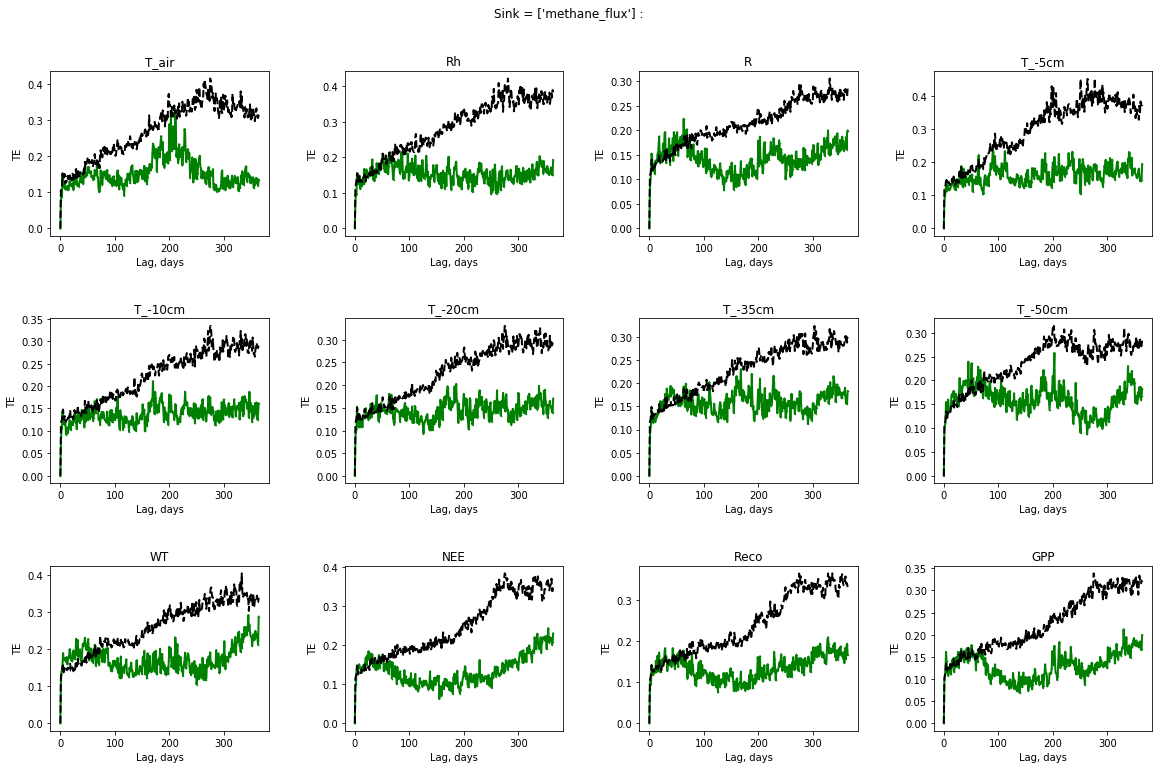

In [49]:
# Step 1/3 
# plotting results of TE one variable at a time
maxLag = 365

n = Tcube_store.shape[1]
plt.figure(figsize=[18,15])
AboveCritic = np.nan*np.ones([n,maxLag])
LagTime = np.nan*np.ones([n])
for i in np.arange(n):
    #i = 0  # Source id

    plt.subplot((int(n/4)+1), 4, i+1)
    plt.plot(np.arange(maxLag), Tcube_store[0,i,:].reshape(maxLag), color='green', marker='o', linewidth=2, markersize=0.5)
    plt.xlabel('Lag, days')
    plt.ylabel('TE')    

    plt.plot(np.arange(maxLag), Tcritcube_store[0,i,:].reshape(maxLag), color = 'black', linewidth=2, linestyle='dashed')
    #plt.title([LabelC[2], 'vs', LabelC[3]]) 
    plt.suptitle('Sink = %s :'%(LabelC[SinN]))
    #plt.title('Source = %s :'%(LabelC[i+2]))
    plt.title((LabelC[SourN[i]]))
    
    #plt.title('Source = %s : Sink = %s'%(LabelC[i+2],LabelC[1]))
    
    #plt.legend(('TE Estimated','TE Critical' ),loc='lower right')

    
    # Locating the critical Time/Delay
    AboveCritic[i,:] = (Tcube_store[0,i,:] - Tcritcube_store[0,i,:]).reshape(maxLag)
    LagTime[i] = np.argwhere(AboveCritic[i,:] == np.nanmax(AboveCritic[i,:]))[0]
    
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5,wspace=0.35)

## Observations and Notes

 - I have now run this in four different ways (1) Untransformed inputs, t-lag; (2) Transformed inputs, t-lag; (3) Untransformed inputs, t-1; and (4) Transformed inputs, t-1. These computations were run out to a lag of 365 days, and the Monte Carlo shuffling has only been done 100 times (change to 1000 for "final" runs). 
 
 - Conditioning on t-1 instead of t-lag results in no patterns of significance differentiable from chance. This makes sense, as the slow, low-frequency deviation from DOY average is not likely to be explained by other variables more than simply knowing the daily variable's anomaly at the last time step.
 - When you condition on t-tau, many variables become significant, up to time lags of about 60 days. Surprisingly, water table seemed particularly important here. 
 - Patterns of significance are stronger for untransformed data than transformed data. That is, large fluctuations away from the norm are more readily explainable by looking at other variables than small fluctuations. 
 
#### To do
 - Plot WT vs methane flux at lag of 5-50 or so days. Maybe also T at 50 cm depth. 

### Plots for non-transformed data (which emphasize extreme behavior)

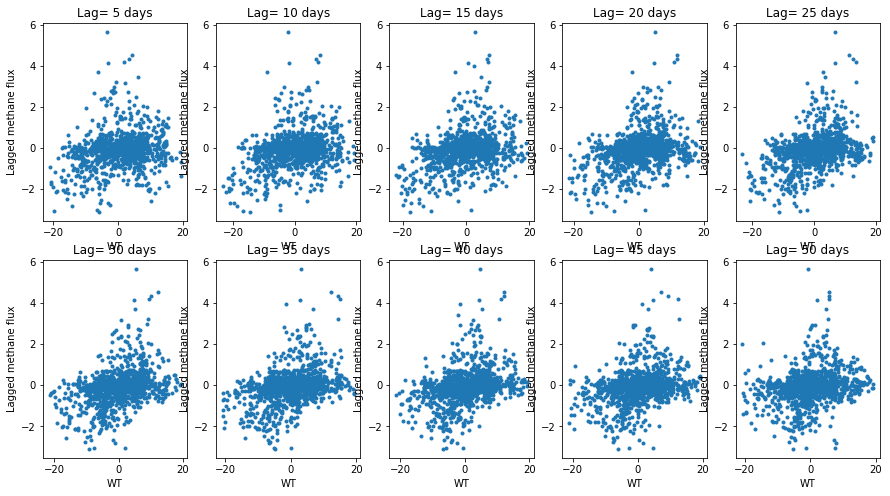

In [52]:
# Plot WT vs methane flux
lag = np.arange(5, 55, 5)
fig, axs = plt.subplots(2,5, figsize = [15, 8])
count1 = 0
count2 = 0
for n in lag:
    y = np.array(AnoTable.iloc[n:]['methane_flux'])
    x = np.array(AnoTable.iloc[:-n]['WT'])
    axs[count1, count2].plot(x,y, '.')
    axs[count1, count2].set_title('Lag= {} days'.format(n))
    axs[count1, count2].set_xlabel('WT')
    axs[count1, count2].set_ylabel('Lagged methane flux')
    count2 = count2+1
    if count2 == 5:
        count2 = 0
        count1 = count1+1


Very high methane fluxes only tend to occur when water table is average to above average (but not hugely above average), with a delay of 20-45 or so days. Very low fluxes tend to occur when water table is below average, with similar lag. 

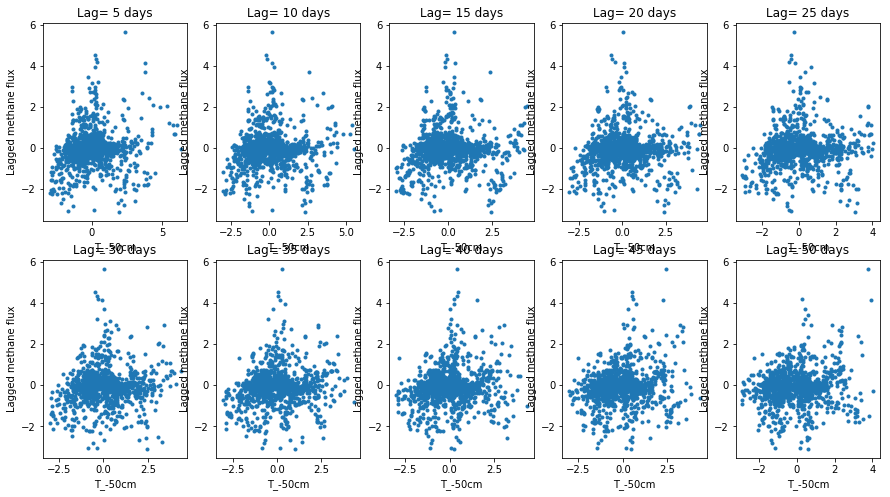

In [55]:
# Plot WT vs T_-50cm
lag = np.arange(5, 55, 5)
fig, axs = plt.subplots(2,5, figsize = [15, 8])
count1 = 0
count2 = 0
for n in lag:
    y = np.array(AnoTable.iloc[n:]['methane_flux'])
    x = np.array(AnoTable.iloc[:-n]['T_-50cm'])
    axs[count1, count2].plot(x,y, '.')
    axs[count1, count2].set_title('Lag= {} days'.format(n))
    axs[count1, count2].set_xlabel('T_-50cm')
    axs[count1, count2].set_ylabel('Lagged methane flux')
    count2 = count2+1
    if count2 == 5:
        count2 = 0
        count1 = count1+1

For temperature at -50 cm, very high values only when temperature near average around 20 days ago. Very low values only when temparature is well above or below average.  Does this reflect water table dynamics?

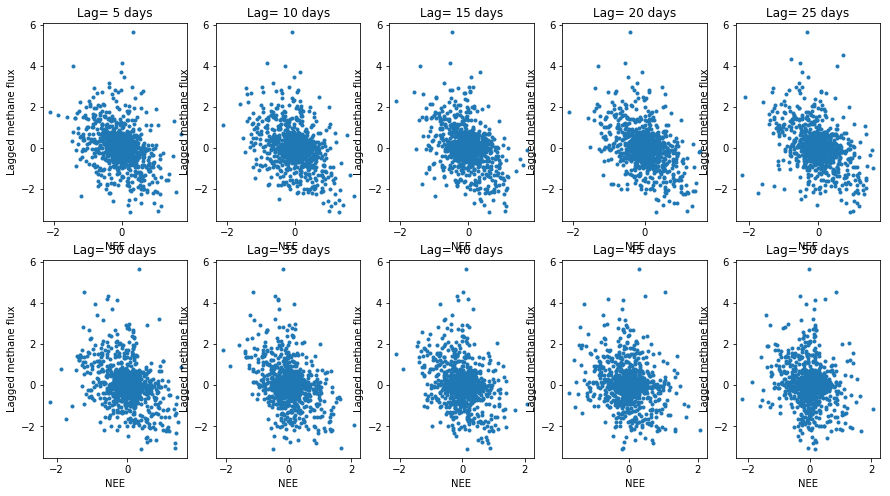

In [56]:
# Plot WT vs NEE
lag = np.arange(5, 55, 5)
fig, axs = plt.subplots(2,5, figsize = [15, 8])
count1 = 0
count2 = 0
for n in lag:
    y = np.array(AnoTable.iloc[n:]['methane_flux'])
    x = np.array(AnoTable.iloc[:-n]['NEE'])
    axs[count1, count2].plot(x,y, '.')
    axs[count1, count2].set_title('Lag= {} days'.format(n))
    axs[count1, count2].set_xlabel('NEE')
    axs[count1, count2].set_ylabel('Lagged methane flux')
    count2 = count2+1
    if count2 == 5:
        count2 = 0
        count1 = count1+1

With a 20-day lag or so, as NEE becomes more positive, methane flux declines. Maybe this is because more aerobic respiration means less methanogenesis, combined with less GPP resulting in less substrate for methanogenesis.

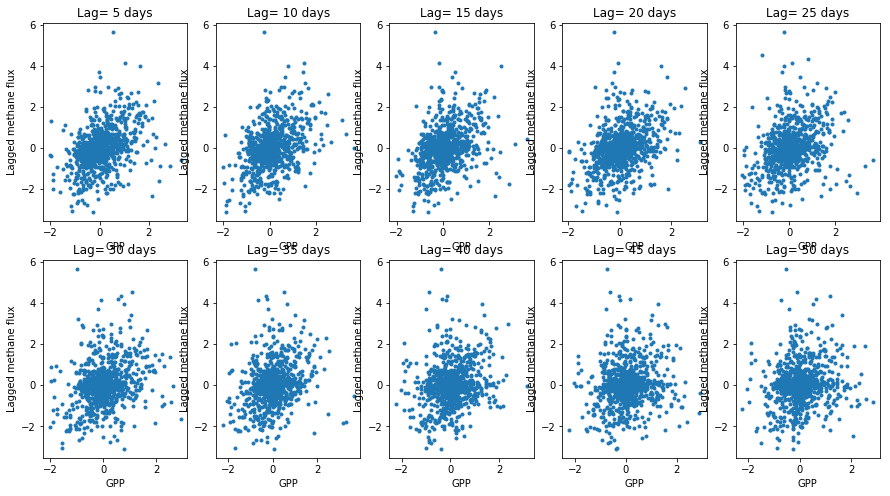

In [57]:
# Plot WT vs GPP
lag = np.arange(5, 55, 5)
fig, axs = plt.subplots(2,5, figsize = [15, 8])
count1 = 0
count2 = 0
for n in lag:
    y = np.array(AnoTable.iloc[n:]['methane_flux'])
    x = np.array(AnoTable.iloc[:-n]['GPP'])
    axs[count1, count2].plot(x,y, '.')
    axs[count1, count2].set_title('Lag= {} days'.format(n))
    axs[count1, count2].set_xlabel('GPP')
    axs[count1, count2].set_ylabel('Lagged methane flux')
    count2 = count2+1
    if count2 == 5:
        count2 = 0
        count1 = count1+1

This shows a positive relationship between GPP and methane flux, strongest around a lag of 10-15 days.

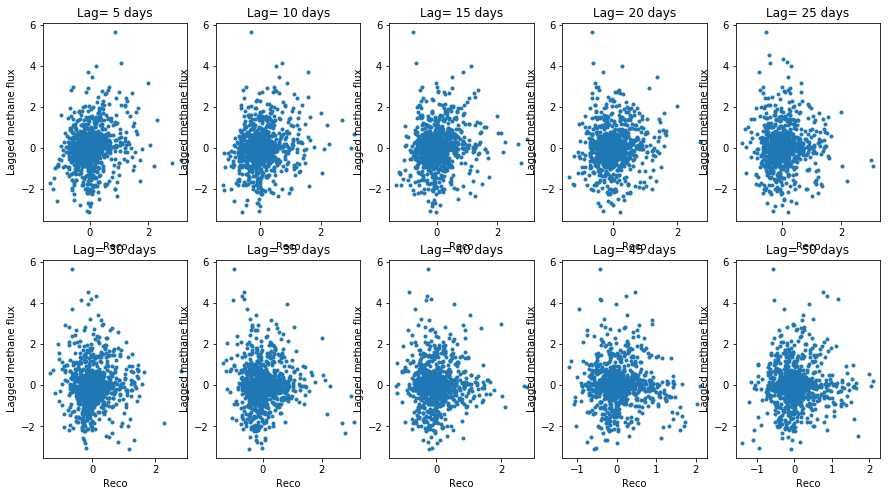

In [59]:
# Plot WT vs Reco
lag = np.arange(5, 55, 5)
fig, axs = plt.subplots(2,5, figsize = [15, 8])
count1 = 0
count2 = 0
for n in lag:
    y = np.array(AnoTable.iloc[n:]['methane_flux'])
    x = np.array(AnoTable.iloc[:-n]['Reco'])
    axs[count1, count2].plot(x,y, '.')
    axs[count1, count2].set_title('Lag= {} days'.format(n))
    axs[count1, count2].set_xlabel('Reco')
    axs[count1, count2].set_ylabel('Lagged methane flux')
    count2 = count2+1
    if count2 == 5:
        count2 = 0
        count1 = count1+1

I don't see much of anything here. CH4 flux anomalies may be driven more by GPP anomalies than respiration.

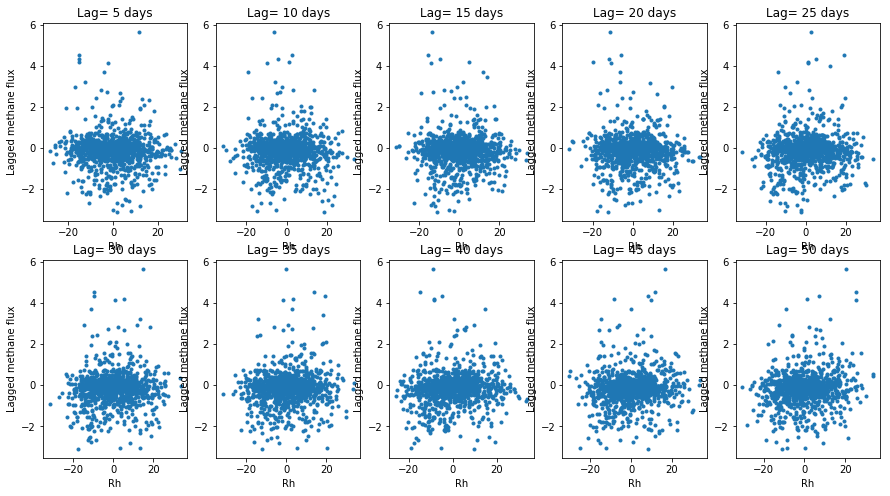

In [60]:
# Plot WT vs Rh
lag = np.arange(5, 55, 5)
fig, axs = plt.subplots(2,5, figsize = [15, 8])
count1 = 0
count2 = 0
for n in lag:
    y = np.array(AnoTable.iloc[n:]['methane_flux'])
    x = np.array(AnoTable.iloc[:-n]['Rh'])
    axs[count1, count2].plot(x,y, '.')
    axs[count1, count2].set_title('Lag= {} days'.format(n))
    axs[count1, count2].set_xlabel('Rh')
    axs[count1, count2].set_ylabel('Lagged methane flux')
    count2 = count2+1
    if count2 == 5:
        count2 = 0
        count1 = count1+1

It seems that only variables consistently above the threshold (rather than above/below in a noisy fashion) have intelligible relationships (with the exception of GPP, which is flirting with the threshold but shows a relationship apparent in the scatterplots for the lags plotted).

### Plots for transformed variables

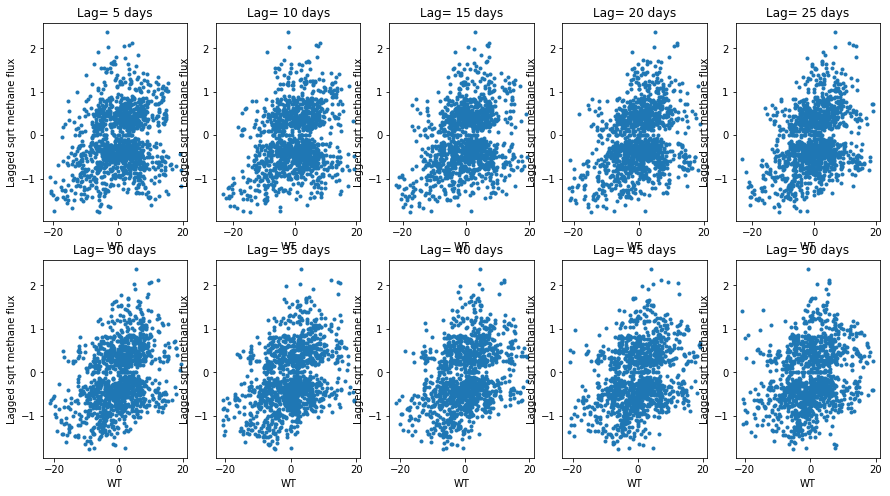

In [62]:
# Plot WT vs methane flux
lag = np.arange(5, 55, 5)
fig, axs = plt.subplots(2,5, figsize = [15, 8])
count1 = 0
count2 = 0
for n in lag:
    y = np.array(AnoTable.iloc[n:]['sqrt_methane_flux'])
    x = np.array(AnoTable.iloc[:-n]['WT'])
    axs[count1, count2].plot(x,y, '.')
    axs[count1, count2].set_title('Lag= {} days'.format(n))
    axs[count1, count2].set_xlabel('WT')
    axs[count1, count2].set_ylabel('Lagged sqrt methane flux')
    count2 = count2+1
    if count2 == 5:
        count2 = 0
        count1 = count1+1

The dynamic of higher WT, higher methane flux really seems to pop here, in almost a threshold fashion. Strongest at lag of 20-25 days.

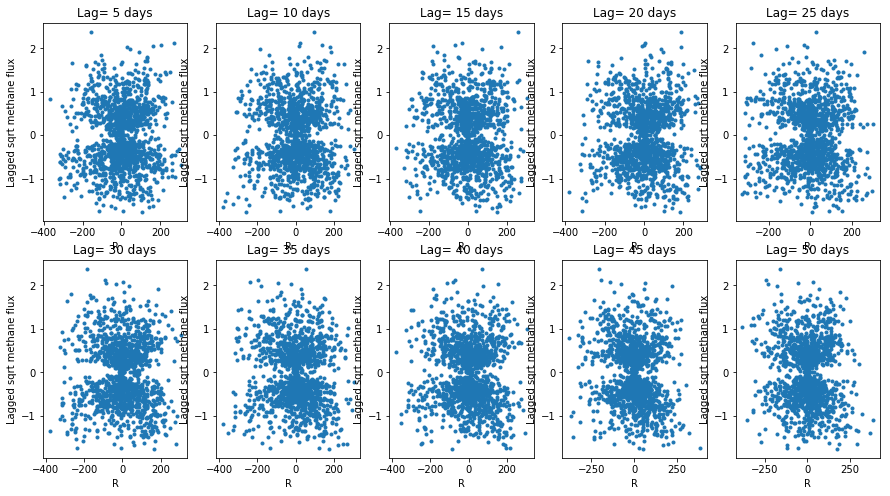

In [64]:
# Plot R vs methane flux
lag = np.arange(5, 55, 5)
fig, axs = plt.subplots(2,5, figsize = [15, 8])
count1 = 0
count2 = 0
for n in lag:
    y = np.array(AnoTable.iloc[n:]['sqrt_methane_flux'])
    x = np.array(AnoTable.iloc[:-n]['R'])
    axs[count1, count2].plot(x,y, '.')
    axs[count1, count2].set_title('Lag= {} days'.format(n))
    axs[count1, count2].set_xlabel('R')
    axs[count1, count2].set_ylabel('Lagged sqrt methane flux')
    count2 = count2+1
    if count2 == 5:
        count2 = 0
        count1 = count1+1

Text(0,0.5,'T_-50cm')

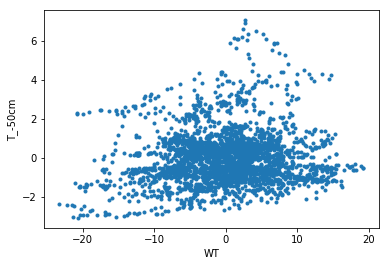

In [87]:
plt.plot(AnoTable['WT'], AnoTable['T_-50cm'], '.')
plt.xlabel('WT')
plt.ylabel('T_-50cm')

C:\Users\Laurel Larsen\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


Text(0.5,0,'TE at Lag (days)')

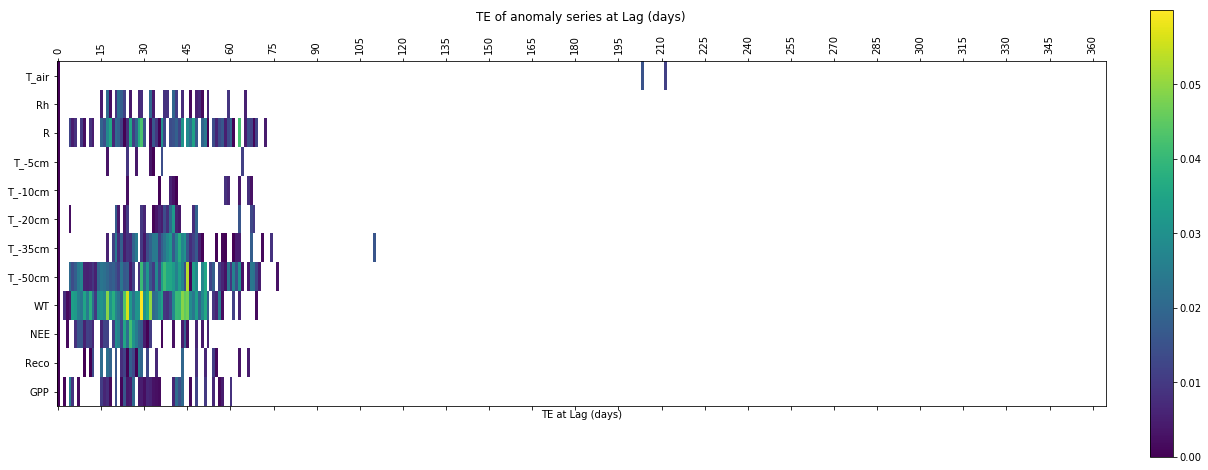

In [84]:
# Step 2/3
# Comparison accross variables
# Assign values less than critical to Nan
indNan = np.argwhere(AboveCritic<0)
AboveCritic[indNan[:,0],indNan[:,1]] = np.nan

names = LabelC[SourN]
minV = np.nanmin(AboveCritic)
maxV = np.nanmax(AboveCritic)

fig = plt.figure(1,figsize = (20,50)) 
ax = fig.add_subplot(111)
cax = ax.matshow(AboveCritic, vmin=minV, vmax=maxV,cmap='viridis', aspect=10) #cmap='ivaris'
ticksY = np.arange(0,names.shape[0],1)
ticksX = np.arange(0,maxLag,15)
ax.set_xticks(ticksX)
ax.set_yticks(ticksY)
ax.set_xticklabels(ticksX)
ax.set_yticklabels(names)
xlabels = ax.get_xticklabels()
ax.set_xticklabels(xlabels, rotation=90)
plt.colorbar(cax,fraction=0.02, pad=0.04)
plt.title('TE of anomaly series at Lag (days)',y=1.1)
plt.xlabel('TE at Lag (days)')

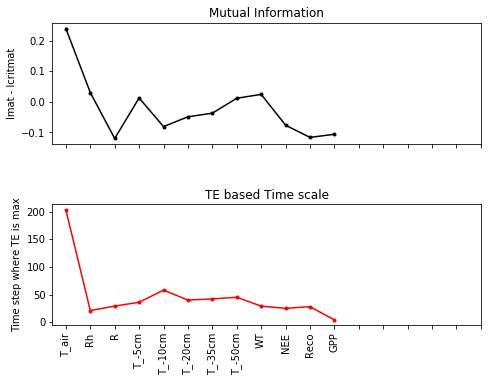

In [85]:
# Step 3/3
# Plotting Critical timescale and Mutual information. Mutual information in this excercise does not include lag. 
plt.figure(figsize=[7,5])
plt.subplot(2,1,1)
plt.plot((Imat-Icritmat).T,'k.-')
plt.ylabel('Imat - Icritmat')
plt.xticks(np.arange(numVr)," ")
plt.title('Mutual Information')
# plt.xticks([]) # hides the tick marks

plt.subplot(2,1,2)
plt.plot((LagTime).T,'r.-')
plt.ylabel('Time step where TE is max')
plt.xticks(np.arange(numVr),names)
plt.xticks(rotation=90)
plt.title('TE based Time scale')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5,wspace=0.35)

### 3. Moving average

In [18]:
# np.sum(d.PRIMET_350_AirTemp[0:5])/6, d.PRIMET_350_AirTemp[0]/6

In [88]:
def movingAverageCalc(data,windowSize):
    b = np.ones(windowSize) / windowSize
    a = np.append(1,np.zeros(windowSize-1))
    y = lfilter(b, a, (np.squeeze(data)))
    return y

In [20]:
# Apply the moving window function
win = 7 
newData = data.iloc.apply(movingAverageCalc, axis=0, windowSize=win) # 
newData[data.columns[0]] = data.loc[:,data.columns[0]]
newData = newData[data.columns] # bring discharge to column 1
newData.head(5)

GSLOOK_discharge  PRIMET_450_AirTemp  PRIMET_350_AirTemp  \
DateTime                                                               
2001-02-21       -118.214286            0.326178            0.269357   
2001-02-22       -109.714286            0.468772            0.336689   
2001-02-23        -99.571429            0.591658            0.379646   
2001-02-24        -95.357143            0.663075            0.370988   
2001-02-25       -104.714286            0.803385            0.448530   

            PRIMET_250_AirTemp  PRIMET_150_AirTemp  PRIMET_450_humidity  \
DateTime                                                                  
2001-02-21            0.231804            0.329592             0.802041   
2001-02-22            0.297176            0.471429             1.318367   
2001-02-23            0.371982            0.613265             1.867347   
2001-02-24            0.389782            0.689796             2.335714   
2001-02-25            0.395713            0.839796             2.524490   

            PRIMET_150_humidity  PRIMET_100_precip  PRIMET_100_solar  \
DateTime                                                               
2001-02-21             0.333673           0.380612         -0.122449   
2001-02-22             0.415306          -0.104082         -2.887755   
2001-02-23             0.460204          -1.002041         -2.816327   
2001-02-24             0.427551          -2.369388          3.163265   
2001-02-25             0.133673          -3.426531          9.428571   

            PRIMET_450_dewPointT       ...        PRIMET_450_vaporPDeficit  \
DateTime                               ...                                   
2001-02-21              0.448980       ...                       -0.065306   
2001-02-22              0.663265       ...                       -0.107143   
2001-02-23              0.891837       ...                       -0.153061   
2001-02-24              1.058163       ...                       -0.172449   
2001-02-25              1.233673       ...                       -0.146939   

            PRIMET_150_vaporPDeficit  PRIMET_10_ST  PRIMET_20_ST  \
DateTime                                                           
2001-02-21                 -0.031633      0.151020     -0.122449   
2001-02-22                 -0.039796      0.357143     -0.208163   
2001-02-23                 -0.051020      0.635714     -0.230612   
2001-02-24                 -0.050000      0.885714     -0.251020   
2001-02-25                  0.015306      1.137755     -0.252041   

            PRIMET_50_ST  PRIMET_100_ST  PRIMET_10_VMC  PRIMET_20_VMC  \
DateTime                                                                
2001-02-21     -0.085714      -0.139796       0.000612      -0.003367   
2001-02-22     -0.139796      -0.270408      -0.000102      -0.006122   
2001-02-23     -0.157143      -0.387755       0.000204      -0.009796   
2001-02-24     -0.141837      -0.488776      -0.001224      -0.013571   
2001-02-25     -0.109184      -0.576531      -0.003673      -0.018367   

            PRIMET_50_VMC  PRIMET_100_VMC  
DateTime                                   
2001-02-21      -0.010816       -0.017551  
2001-02-22      -0.021429       -0.036633  
2001-02-23      -0.025510       -0.055204  
2001-02-24      -0.029592       -0.067755  
2001-02-25      -0.033571       -0.079184  

[5 rows x 23 columns]

In [21]:
# Adjust input for TE 
Table = copy.deepcopy(newData)
numVr =  Table.shape[1] #3
data = copy.deepcopy(Table.iloc[:,np.arange(numVr)])
SourN = np.arange(2,numVr+1)  # np.array([2,3])
SinN = np.array([1])
LabelC = np.r_[np.array('DateTime'),np.array(data.columns)]
DataM = pd.np.column_stack((data.index.astype(str), data.values))

LabelC, DataM[0:5,2], (data.shape)

(array(['DateTime', 'GSLOOK_discharge', 'PRIMET_450_AirTemp',
        'PRIMET_350_AirTemp', 'PRIMET_250_AirTemp', 'PRIMET_150_AirTemp',
        'PRIMET_450_humidity', 'PRIMET_150_humidity', 'PRIMET_100_precip',
        'PRIMET_100_solar', 'PRIMET_450_dewPointT', 'PRIMET_150_dewPointT',
        'PRIMET_450_vaporPressure', 'PRIMET_150_vaporPressure',
        'PRIMET_450_vaporPDeficit', 'PRIMET_150_vaporPDeficit',
        'PRIMET_10_ST', 'PRIMET_20_ST', 'PRIMET_50_ST', 'PRIMET_100_ST',
        'PRIMET_10_VMC', 'PRIMET_20_VMC', 'PRIMET_50_VMC',
        'PRIMET_100_VMC'], dtype=object),
 array([0.3261781975711471, 0.46877216562427315, 0.5916576218856034,
        0.6630754561981579, 0.8033848092186081], dtype=object),
 (5062, 23))

In [ ]:
# Applying TE on the moving average data
sf = [-1,0,-1]
Imat, Icritmat, Tfirstmat,  Tbiggestmat,Tcube_store,  Tcritcube_store = TEpython2.RunNewTE2VarsSer2(DataMatrix= DataM,
                                            LabelCell=LabelC, shift=sf, SinkNodes= SinN,SourceNodes=SourN, maxLag=maxLag)

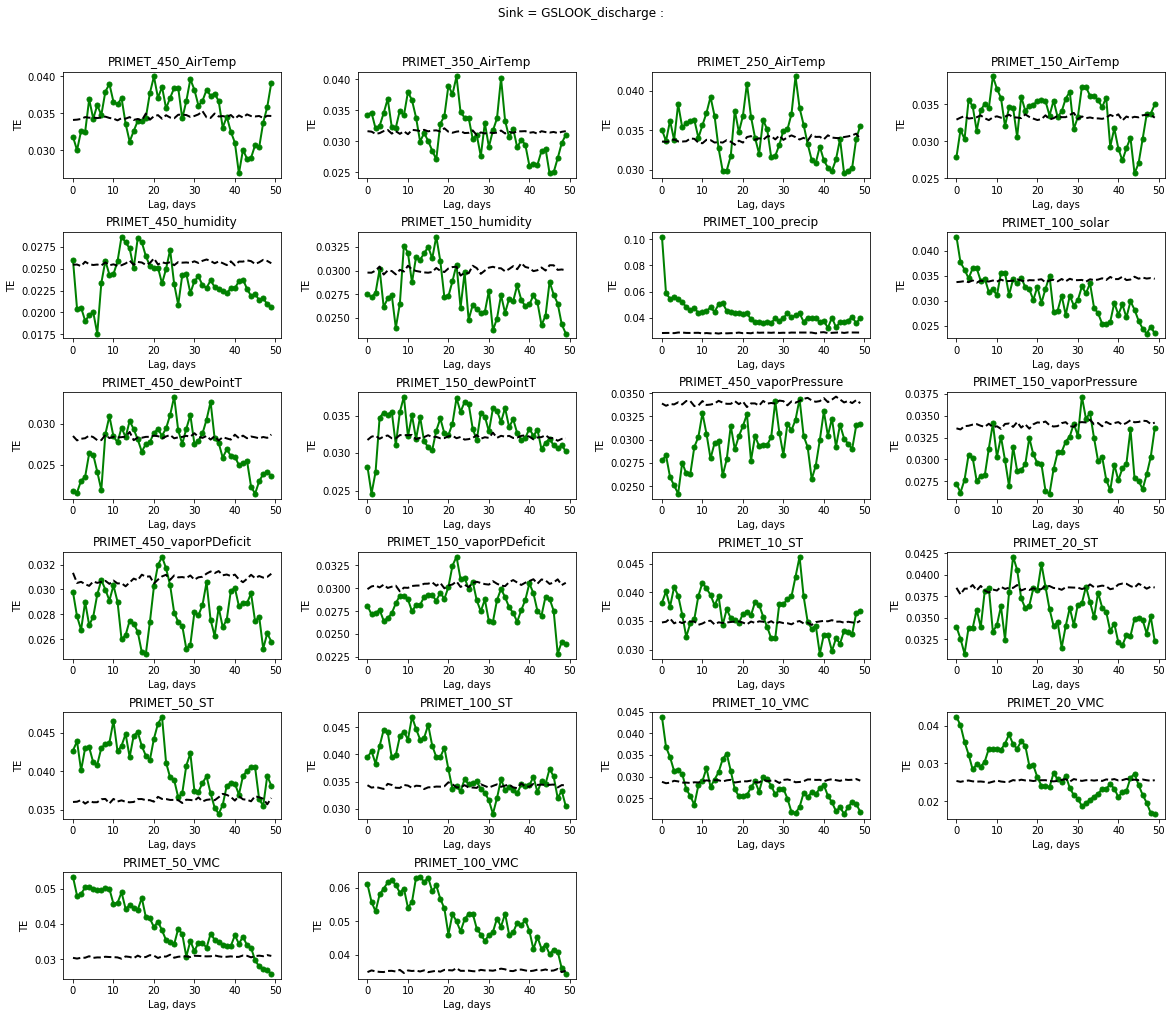

In [23]:
# Step 1/3 
# plotting results of TE one variable at a time

n = Tcube_store.shape[1]
plt.figure(figsize=[18,15])
AboveCritic = np.nan*np.ones([n,maxLag])
LagTime = np.nan*np.ones([n])
for i in np.arange(n):
    #i = 0  # Source id

    plt.subplot((int(n/4)+1), 4, i+1)
    plt.plot(np.arange(maxLag), Tcube_store[0,i,:].reshape(maxLag), color='green', marker='o', linewidth=2, markersize=5)
    plt.xlabel('Lag, days')
    plt.ylabel('TE')    

    plt.plot(np.arange(maxLag), Tcritcube_store[0,i,:].reshape(maxLag), color = 'black', linewidth=2, linestyle='dashed')
    #plt.title([LabelC[2], 'vs', LabelC[3]]) 
    plt.suptitle('Sink = %s :'%(LabelC[1]))
    #plt.title('Source = %s :'%(LabelC[i+2]))
    plt.title((LabelC[i+2]))
    
    #plt.title('Source = %s : Sink = %s'%(LabelC[i+2],LabelC[1]))
    
    #plt.legend(('TE Estimated','TE Critical' ),loc='lower right')

    
    # Locating the critical Time/Delay
    AboveCritic[i,:] = (Tcube_store[0,i,:] - Tcritcube_store[0,i,:]).reshape(maxLag)
    LagTime[i] = np.argwhere(AboveCritic[i,:] == np.nanmax(AboveCritic[i,:]))[0]
    
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5,wspace=0.35)

C:\Users\edom.moges\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Text(0.5,0,'TE at Lag (days)')

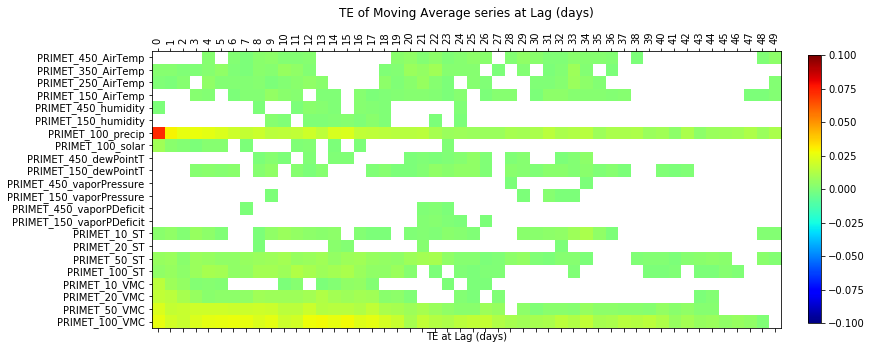

In [24]:
# Step 2/3
# Comparison accross variables
# Assign values less than critical to Nan
indNan = np.argwhere(AboveCritic<0)
AboveCritic[indNan[:,0],indNan[:,1]] = np.nan

names = LabelC[2:]
minV = np.min(AboveCritic)
maxV = np.max(AboveCritic)

fig = plt.figure(1,figsize = (12,10)) 
ax = fig.add_subplot(111)
cax = ax.matshow(AboveCritic, vmin=minV, vmax=maxV,cmap='jet') #cmap='ivaris'
ticksY = np.arange(0,names.shape[0],1)
ticksX = np.arange(0,maxLag,1)
ax.set_xticks(ticksX)
ax.set_yticks(ticksY)
ax.set_xticklabels(np.arange(maxLag))
ax.set_yticklabels(names)
xlabels = ax.get_xticklabels()
ax.set_xticklabels(xlabels, rotation=90)
plt.colorbar(cax,fraction=0.02, pad=0.04)
plt.title('TE of Moving Average series at Lag (days)',y=1.1)
plt.xlabel('TE at Lag (days)')

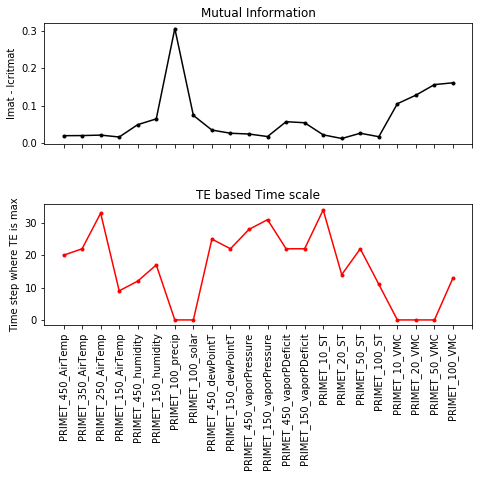

In [25]:
# Step 3/3
# Plotting Critical timescale and Mutual information. Mutual information in this excercise does not include lag. 
plt.figure(figsize=[7,5])
plt.subplot(2,1,1)
plt.plot((Imat-Icritmat).T,'k.-')
plt.ylabel('Imat - Icritmat')
plt.xticks(np.arange(numVr)," ")
plt.title('Mutual Information')
# plt.xticks([]) # hides the tick marks

plt.subplot(2,1,2)
plt.plot((LagTime).T,'r.-')
plt.ylabel('Time step where TE is max')
plt.xticks(np.arange(numVr),names)
plt.xticks(rotation=90)
plt.title('TE based Time scale')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5,wspace=0.35)

### 3.1 Moving avarage on the anomaly data series

    This section is intended to analyse the implication of weekly (& monthly, seasonal) memory on daily streamflow.

In [ ]:
AnoMovingTable = movingAverageCalc(data=AnoTable,windowSize=win) #left for potential excercise

### 4. Aggregation
The analysis in this section is based on weekly aggregtion where both predictor (hydrometeorology) and predicted (streamflow) variables are aggregated to a weekly resolution. Weekly timescale is choosen because of data length. Monthly/seasonal can lead to poor binning.

In [26]:
# analysis on a Weekly/monthly time resolution
def aggregationFun(table):
    
    years = np.arange(table.index.year.min(),1+table.index.year.max())
    df2 = np.ones([1,np.shape(table.columns)[0]])
    for yr in years:

        df = table.loc[table.index.year==yr,table.columns[:]]
        df.groupby(df.index.week).mean()
        df2 = np.r_[df2, df.groupby(df.index.week).mean() ]
        # print(yr, len(df.groupby(df.index.week).mean()))  

    df3 = pd.DataFrame(columns=table.columns,data=df2)
    #df3.head(5)
    return(df3)

In [27]:
# analysis on a Weekly/monthly time resolution
AggRaw = aggregationFun(table=table)

### Agreggation on raw data

In [28]:
# Adjust input for TE 

Table = copy.deepcopy(AggRaw)
numVr =  Table.shape[1] #3
data = copy.deepcopy(Table.iloc[:,np.arange(numVr)])
SourN = np.arange(2,numVr+1)  # np.array([2,3])
SinN = np.array([1])
LabelC = np.r_[np.array('DateTime'),np.array(data.columns)]
DataM = pd.np.column_stack((data.index.astype(str), data.values))

LabelC, DataM[0:5,2], (data.shape)

(array(['DateTime', 'GSLOOK_discharge', 'PRIMET_450_AirTemp',
        'PRIMET_350_AirTemp', 'PRIMET_250_AirTemp', 'PRIMET_150_AirTemp',
        'PRIMET_450_humidity', 'PRIMET_150_humidity', 'PRIMET_100_precip',
        'PRIMET_100_solar', 'PRIMET_450_dewPointT', 'PRIMET_150_dewPointT',
        'PRIMET_450_vaporPressure', 'PRIMET_150_vaporPressure',
        'PRIMET_450_vaporPDeficit', 'PRIMET_150_vaporPDeficit',
        'PRIMET_10_ST', 'PRIMET_20_ST', 'PRIMET_50_ST', 'PRIMET_100_ST',
        'PRIMET_10_VMC', 'PRIMET_20_VMC', 'PRIMET_50_VMC',
        'PRIMET_100_VMC'], dtype=object),
 array([1.0, 3.6, 3.72, 2.3285714285714287, 5.6], dtype=object),
 (727, 23))

In [ ]:
%%time
# Applying TE on the moving average data
sf = [-1,0,-1]
Imat, Icritmat, Tfirstmat,  Tbiggestmat,Tcube_store,  Tcritcube_store = TEpython2.RunNewTE2VarsSer2(DataMatrix= DataM,
                                            LabelCell=LabelC, shift=sf, SinkNodes= SinN,SourceNodes=SourN, maxLag=maxLag)

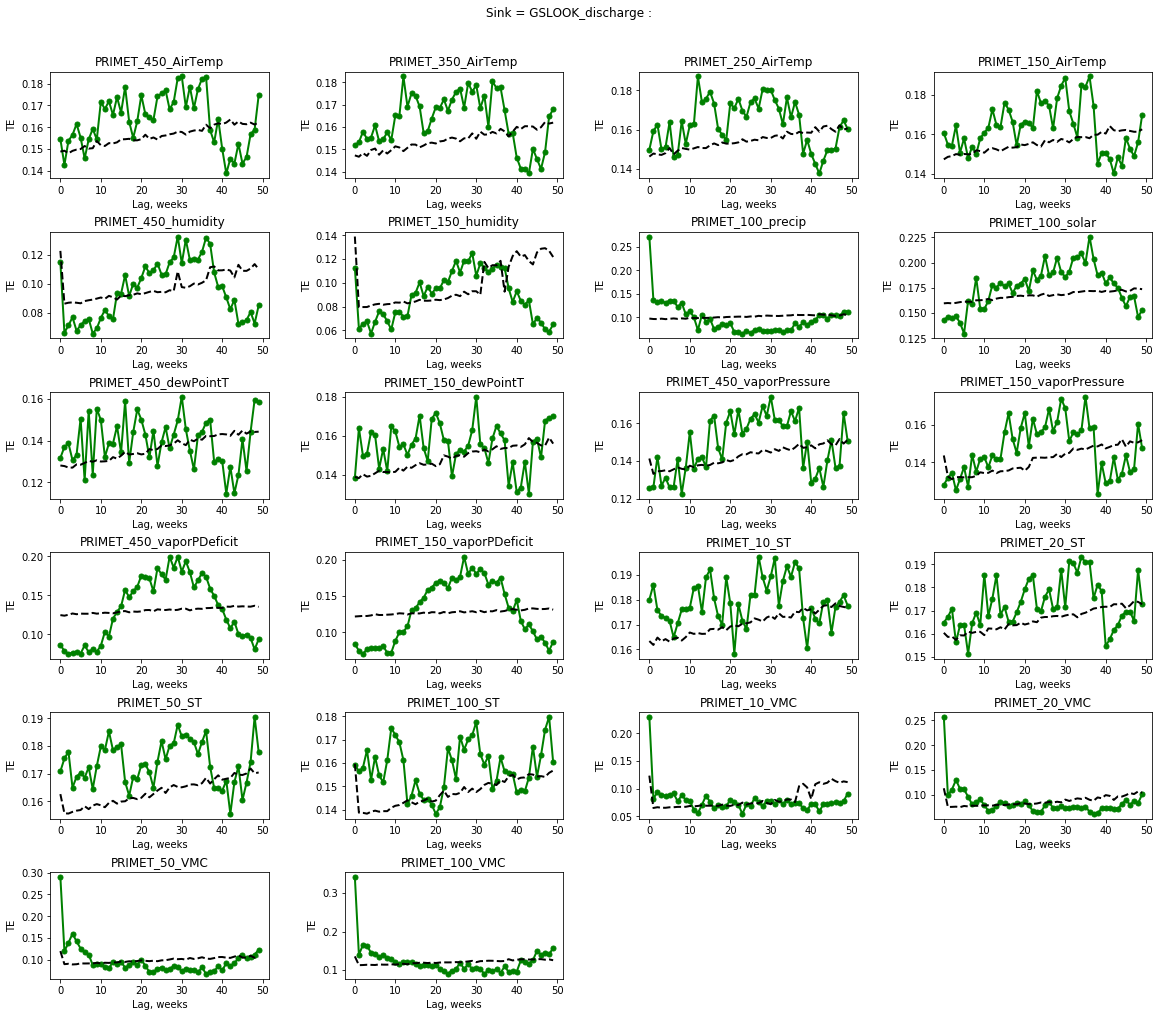

In [30]:
# Step 1/3 
# plotting results of TE one variable at a time
n = Tcube_store.shape[1]
plt.figure(figsize=[18,15])
AboveCritic = np.nan*np.ones([n,maxLag])
LagTime = np.nan*np.ones([n])
for i in np.arange(n):
    #i = 0  # Source id

    plt.subplot((int(n/4)+1), 4, i+1)
    plt.plot(np.arange(maxLag), Tcube_store[0,i,:].reshape(maxLag), color='green', marker='o', linewidth=2, markersize=5)
    plt.xlabel('Lag, weeks')
    plt.ylabel('TE')    

    plt.plot(np.arange(maxLag), Tcritcube_store[0,i,:].reshape(maxLag), color = 'black', linewidth=2, linestyle='dashed')
    #plt.title([LabelC[2], 'vs', LabelC[3]]) 
    plt.suptitle('Sink = %s :'%(LabelC[1]))
    #plt.title('Source = %s :'%(LabelC[i+2]))
    plt.title((LabelC[i+2]))
    
    #plt.title('Source = %s : Sink = %s'%(LabelC[i+2],LabelC[1]))
    
    #plt.legend(('TE Estimated','TE Critical' ),loc='lower right')

    
    # Locating the critical Time/Delay
    AboveCritic[i,:] = (Tcube_store[0,i,:] - Tcritcube_store[0,i,:]).reshape(maxLag)
    LagTime[i] = np.argwhere(AboveCritic[i,:] == np.nanmax(AboveCritic[i,:]))[0]
    
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5,wspace=0.35)

C:\Users\edom.moges\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Text(0.5,1.1,'TE of Weekly aggregated Raw dataLag (weeks)')

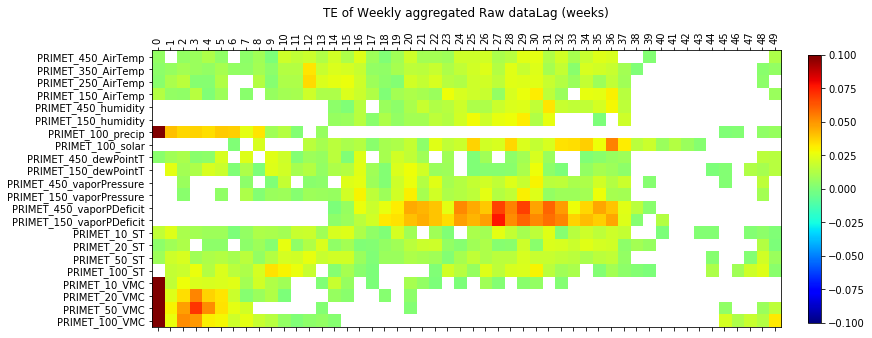

In [31]:
# Step 2/3
# Comparison accross variables
# Assign values less than critical to Nan
indNan = np.argwhere(AboveCritic<0)
AboveCritic[indNan[:,0],indNan[:,1]] = np.nan

names = LabelC[2:]
minV = np.min(AboveCritic)
maxV = np.max(AboveCritic)

fig = plt.figure(1,figsize = (12,10)) 
ax = fig.add_subplot(111)
cax = ax.matshow(AboveCritic, vmin=minV, vmax=maxV,cmap='jet') #cmap='ivaris'
ticksY = np.arange(0,names.shape[0],1)
ticksX = np.arange(0,maxLag,1)
ax.set_xticks(ticksX)
ax.set_yticks(ticksY)
ax.set_xticklabels(np.arange(maxLag))
ax.set_yticklabels(names)
xlabels = ax.get_xticklabels()
ax.set_xticklabels(xlabels, rotation=90)
plt.colorbar(cax,fraction=0.02, pad=0.04)
plt.title('TE of Weekly aggregated Raw dataLag (weeks)',y=1.1)
#plt.xlabel('TE at Lag (days)')

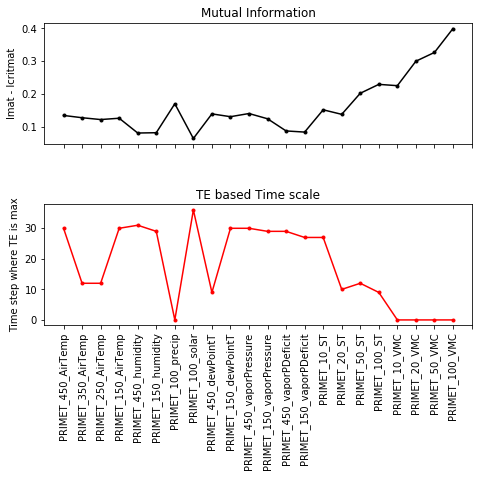

In [32]:
# Step 3/3
# Plotting Critical timescale and Mutual information. Mutual information in this excercise does not include lag. 
plt.figure(figsize=[7,5])
plt.subplot(2,1,1)
plt.plot((Imat-Icritmat).T,'k.-')
plt.ylabel('Imat - Icritmat')
plt.xticks(np.arange(numVr)," ")
plt.title('Mutual Information')
# plt.xticks([]) # hides the tick marks

plt.subplot(2,1,2)
plt.plot((LagTime).T,'r.-')
plt.ylabel('Time step where TE is max')
plt.xticks(np.arange(numVr),names)
plt.xticks(rotation=90)
plt.title('TE based Time scale')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5,wspace=0.35)

### Aggregation on anomaly data

In [33]:
AggAnoTable = aggregationFun(AnoTable)

In [34]:
# Adjust input for TE 
Table = copy.deepcopy(AggAnoTable)
numVr =  Table.shape[1] #3
data = copy.deepcopy(Table.iloc[:,np.arange(numVr)])
SourN = np.arange(2,numVr+1)  # np.array([2,3])
SinN = np.array([1])
LabelC = np.r_[np.array('DateTime'),np.array(data.columns)]
DataM = pd.np.column_stack((data.index.astype(str), data.values))

LabelC, DataM[0:5,2], (data.shape)

(array(['DateTime', 'GSLOOK_discharge', 'PRIMET_450_AirTemp',
        'PRIMET_350_AirTemp', 'PRIMET_250_AirTemp', 'PRIMET_150_AirTemp',
        'PRIMET_450_humidity', 'PRIMET_150_humidity', 'PRIMET_100_precip',
        'PRIMET_100_solar', 'PRIMET_450_dewPointT', 'PRIMET_150_dewPointT',
        'PRIMET_450_vaporPressure', 'PRIMET_150_vaporPressure',
        'PRIMET_450_vaporPDeficit', 'PRIMET_150_vaporPDeficit',
        'PRIMET_10_ST', 'PRIMET_20_ST', 'PRIMET_50_ST', 'PRIMET_100_ST',
        'PRIMET_10_VMC', 'PRIMET_20_VMC', 'PRIMET_50_VMC',
        'PRIMET_100_VMC'], dtype=object),
 array([1.0, 3.5366773608957334, 1.1247387329060516, -0.7732237360401635,
        1.5797125248707344], dtype=object),
 (727, 23))

In [ ]:
%%time
# Applying TE on the moving average data
sf = [-1,0,-1]
Imat, Icritmat, Tfirstmat,  Tbiggestmat,Tcube_store,  Tcritcube_store = TEpython2.RunNewTE2VarsSer2(DataMatrix= DataM,
                                            LabelCell=LabelC, shift=sf, SinkNodes= SinN,SourceNodes=SourN, maxLag=maxLag)

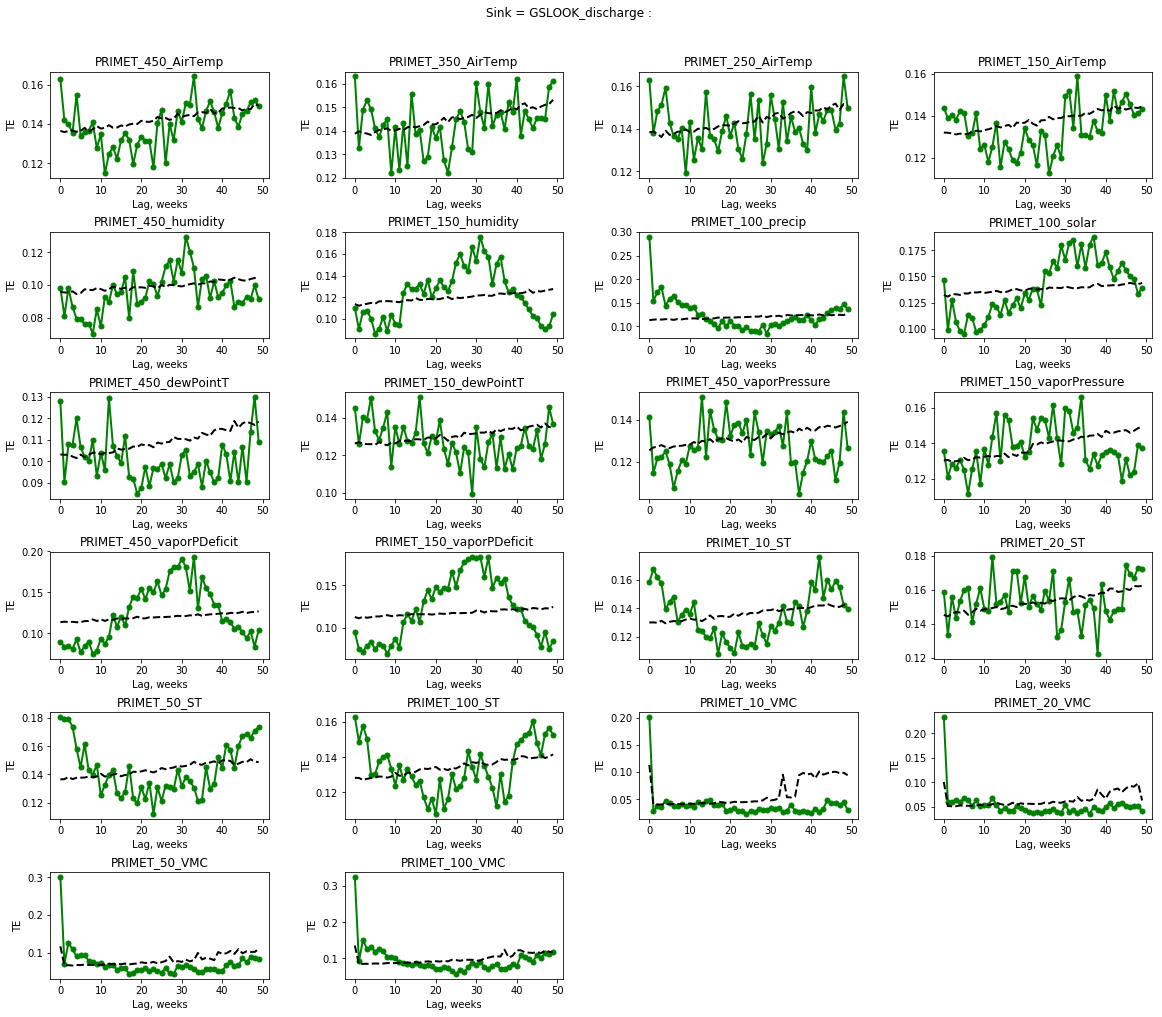

In [36]:
# Step 1/3 
# plotting results of TE one variable at a time
n = Tcube_store.shape[1]
plt.figure(figsize=[18,15])
AboveCritic = np.nan*np.ones([n,maxLag])
LagTime = np.nan*np.ones([n])
for i in np.arange(n):
    #i = 0  # Source id

    plt.subplot((int(n/4)+1), 4, i+1)
    plt.plot(np.arange(maxLag), Tcube_store[0,i,:].reshape(maxLag), color='green', marker='o', linewidth=2, markersize=5)
    plt.xlabel('Lag, weeks')
    plt.ylabel('TE')    

    plt.plot(np.arange(maxLag), Tcritcube_store[0,i,:].reshape(maxLag), color = 'black', linewidth=2, linestyle='dashed')
    #plt.title([LabelC[2], 'vs', LabelC[3]]) 
    plt.suptitle('Sink = %s :'%(LabelC[1]))
    #plt.title('Source = %s :'%(LabelC[i+2]))
    plt.title((LabelC[i+2]))
    
    #plt.title('Source = %s : Sink = %s'%(LabelC[i+2],LabelC[1]))
    
    #plt.legend(('TE Estimated','TE Critical' ),loc='lower right')

    
    # Locating the critical Time/Delay
    AboveCritic[i,:] = (Tcube_store[0,i,:] - Tcritcube_store[0,i,:]).reshape(maxLag)
    LagTime[i] = np.argwhere(AboveCritic[i,:] == np.nanmax(AboveCritic[i,:]))[0]
    
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5,wspace=0.35)

C:\Users\edom.moges\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.
C:\Users\edom.moges\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Text(0.5,1.1,'TE of Weekly aggregated Anomaly Lag (weeks)')

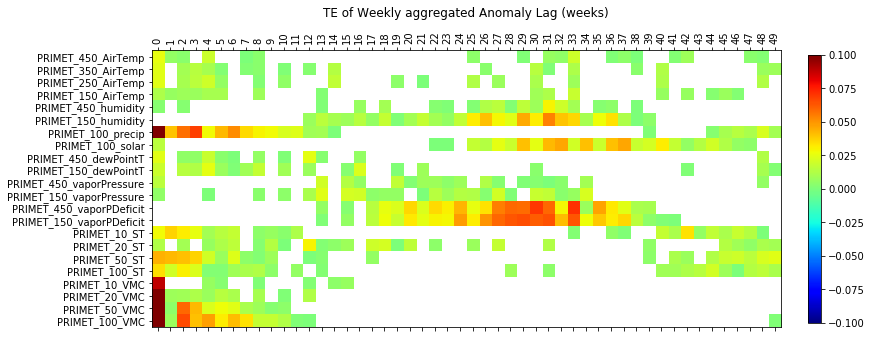

In [39]:
# Step 2/3
# Comparison accross variables
# Assign values less than critical to Nan
indNan = np.argwhere(AboveCritic<0)
AboveCritic[indNan[:,0],indNan[:,1]] = np.nan

names = LabelC[2:]
minV = np.min(AboveCritic)
maxV = np.max(AboveCritic)

fig = plt.figure(1,figsize = (12,10)) 
ax = fig.add_subplot(111)
cax = ax.matshow(AboveCritic, vmin=minV, vmax=maxV,cmap='jet') #cmap='ivaris'
ticksY = np.arange(0,names.shape[0],1)
ticksX = np.arange(0,maxLag,1)
ax.set_xticks(ticksX)
ax.set_yticks(ticksY)
ax.set_xticklabels(np.arange(maxLag))
ax.set_yticklabels(names)
xlabels = ax.get_xticklabels()
ax.set_xticklabels(xlabels, rotation=90)
plt.colorbar(cax,fraction=0.02, pad=0.04)
plt.title('TE of Weekly aggregated Anomaly Lag (weeks)',y=1.1)
#plt.xlabel('TE at Lag (days)')

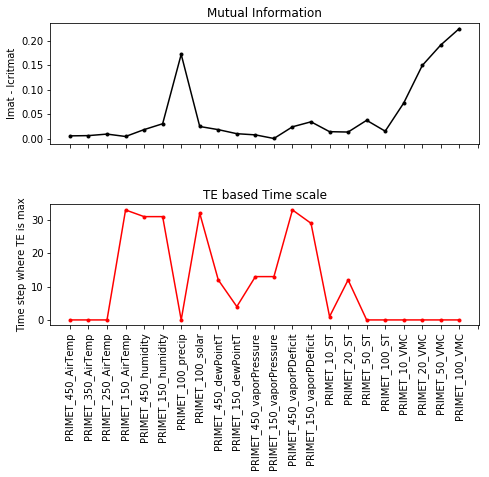

In [40]:
# Step 3/3
# Plotting Critical timescale and Mutual information. Mutual information in this excercise does not include lag. 
plt.figure(figsize=[7,5])
plt.subplot(2,1,1)
plt.plot((Imat-Icritmat).T,'k.-')
plt.ylabel('Imat - Icritmat')
plt.xticks(np.arange(numVr)," ")
plt.title('Mutual Information')
# plt.xticks([]) # hides the tick marks

plt.subplot(2,1,2)
plt.plot((LagTime).T,'r.-')
plt.ylabel('Time step where TE is max')
plt.xticks(np.arange(numVr),names)
plt.xticks(rotation=90)
plt.title('TE based Time scale')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5,wspace=0.35)